In [2]:
import time
import hydra
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
import matplotlib.pyplot as plt
import torch
from collector import Collector
import yaml

#/users/junzheyin/iris1/outputs/2023-11-04/09-22-53/config/trainer.yaml
with open('/users/junzheyin/iris1/outputs/2023-11-30/17-20-45/config/trainer.yaml', 'r') as config_file:
    cfg = yaml.safe_load(config_file)
cfg.keys()

dict_keys(['wandb', 'initialization', 'checkpoint_OPT', 'common', 'collection', 'training', 'evaluation', 'tokenizer', 'world_model'])

In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda:1")
    print("CUDA device is available")
else:
    device = torch.device("cpu")
    print("CUDA device is not available")

print("Device:", device)
print(torch.__version__)
print(torch.version.cuda)
import torch

CUDA device is available
Device: cuda:1
1.11.0
11.3


In [4]:
# Define dataset
import torch
import sys
from nuwa_pytorch import VQGanVAE
import h5py
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import torch.nn.functional as F
def eventGeneration(start_time, obs_time = 3 ,lead_time = 6, time_interval = 30):
    # Generate event based on starting time point, return a list: [[t-4,...,t-1,t], [t+1,...,t+72]]
    # Get the start year, month, day, hour, minute
    year = int(start_time[0:4])
    month = int(start_time[4:6])
    day = int(start_time[6:8])
    hour = int(start_time[8:10])
    minute = int(start_time[10:12])
    #print(datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    times = [(datetime(year, month, day, hour, minute) + timedelta(minutes=time_interval * (x+1))) for x in range(lead_time)]
    lead = [dt.strftime('%Y%m%d%H%M') for dt in times]
    times = [(datetime(year, month, day, hour, minute) - timedelta(minutes=time_interval * x)) for x in range(obs_time)]
    obs = [dt.strftime('%Y%m%d%H%M') for dt in times]
    obs.reverse()
    return lead, obs

from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from torchvision.transforms import ToTensor, Compose, CenterCrop
class radarDataset(Dataset):
    def __init__(self, root_dir, event_times, obs_number = 3, pred_number = 6, transform=None):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.transform = transform
        self.event_times = event_times
        self.obs_number = obs_number
        self.pred_number = pred_number
    def __len__(self):
        return len(self.event_times)
    def __getitem__(self, idx):
        start_time = str(self.event_times[idx])
        time_list_pre, time_list_obs = eventGeneration(start_time, self.obs_number, self.pred_number)
        output = []
        time_list = time_list_obs + time_list_pre
        #print(time_list)
        for time in time_list:
            year = time[0:4]
            month = time[4:6]
            #path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + time + '_NL.h5'
            path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAP_5min_' + time + '.h5'
            image = np.array(h5py.File(path)['image1']['image_data'])
            #image = np.ma.masked_where(image == 65535, image)
            image = image[264:520,242:498]
            image[image == 65535] = 0
            image = image.astype('float32')
            image = image/100*12
            image = np.clip(image, 0, 128)
            image = image/40
            #image = 2*image-1 #normalize to [-1,1]
            output.append(image)
        output = torch.permute(torch.tensor(np.array(output)), (1, 2, 0))
        output = self.transform(np.array(output))
        output = torch.tensor((np.array(output)), dtype = torch.float32)
        # Reshape tensor to include a batch dimension (B, C, H, W)
        output = output.unsqueeze(0)
        # Resize tensor using F.interpolate
        output = F.interpolate(output, size=(128, 128), mode='bilinear', align_corners=False)
        # Remove batch dimension
        output = torch.squeeze(output, 0) # output : [C, H, W]
        return output
#root_dir = '/users/hbi/data/RAD_NL25_RAC_MFBS_EM_5min/'
#dataset = radarDataset(root_dir, ["200808031600"], transform = Compose([ToTensor(),CenterCrop(256)]))


In [5]:
# develop dataset
from torch.cuda.amp import autocast
from torch.autograd import Variable
from torch import optim
import pandas as pd
root_dir = '/space/junzheyin/RAD_NL25_RAP_5min/' 

# M-L, top 5%
df_train = pd.read_csv('/users/hbi/taming-transformers/training_Delfland08-14.csv', header = None)
event_times = df_train[0].to_list()
dataset_train = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))           

df_test = pd.read_csv('/users/hbi/taming-transformers/testing_Delfland18-20.csv', header = None)
event_times = df_test[0].to_list()
dataset_test = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali = pd.read_csv('/users/hbi/taming-transformers/validation_Delfland15-17.csv', header = None)
event_times = df_vali[0].to_list()
dataset_vali = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_train_aa = pd.read_csv('/users/hbi/taming-transformers/training_Aa08-14.csv', header = None)
event_times = df_train_aa[0].to_list()
dataset_train_aa = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

df_train_dw = pd.read_csv('/users/hbi/taming-transformers/training_Dwar08-14.csv', header = None)
event_times = df_train_dw[0].to_list()
dataset_train_dw = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))   

df_train_re = pd.read_csv('/users/hbi/taming-transformers/training_Regge08-14.csv', header = None)
event_times = df_train_re[0].to_list()
dataset_train_re = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

# extreme, top 1%
df_train_ext = pd.read_csv('/users/hbi/taming-transformers/training_Delfland08-14_ext.csv', header = None)
event_times = df_train_ext[0].to_list()
mfbs = df_train_ext[1].to_list()
dic_mfbs1 = dict(zip(event_times, mfbs))
dataset_train_ext = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))           

df_test_ext = pd.read_csv('/users/hbi/taming-transformers/testing_Delfland18-20_ext.csv', header = None)
event_times = df_test_ext[0].to_list()
mfbs = df_test_ext[1].to_list()
dic_mfbs2 = dict(zip(event_times, mfbs))
dataset_test_ext = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali_ext = pd.read_csv('/users/hbi/taming-transformers/validation_Delfland15-17_ext.csv', header = None)
event_times = df_vali_ext[0].to_list()
mfbs = df_vali_ext[1].to_list()
dic_mfbs3 = dict(zip(event_times, mfbs))
dataset_vali_ext = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

dic_mfbs = {}
dic_mfbs.update(dic_mfbs1)
dic_mfbs.update(dic_mfbs2)
dic_mfbs.update(dic_mfbs3)
#new_valid = ['201606222325', '201508131920', '201606230050', '201606230100', '201606230200', '201508261735', '201508261800', '201708300255', '201708300300', '201707291755', '201707291800', '201606201210', '201708300155', '201606230300', '201707120520', '201707120600', '201707120455', '201708300055', '201707120700', '201605301745', '201509041820', '201605301800', '201709081725', '201606201300', '201708300420', '201709081650', '201509041755', '201709081545', '201709081455', '201709141200', '201709141155', '201709081800', '201508132000', '201707062000', '201707061955', '201711270745', '201709141300', '201709141055', '201605301655', '201709081900', '201708300500', '201805291515', '202006171920', '201805291455', '201809050545', '202006171855', '201809050600', '201906150240', '201906150300', '202008161555', '202008161600', '201805291600', '202006122025', '201906150155', '201906120820', '201906052100', '202006171755', '201906120755', '201808242240', '201804292310', '201906120940', '202007252055', '201804292255', '201808242300', '202007252100', '201906121000', '202006172000', '201809050700', '202002091830', '202009232020', '201808101930', '201808242050', '201906150400', '201808242100', '202002091900', '202006050545', '201910210430', '202007251955', '201808102000', '201804102045', '201804300000', '201804102100', '201906052200', '201808101820', '202006050600', '201810300150', '201906052300', '201810300200', '201804102200', '201808101755', '201910061250', '201810300300', '202009232100']

new_valid = ['201903070300', '201903070315', '201904241715', '201904241730', '201904241745', '201904241800', '201904241815', '201904241830', '201904241845', '201904241900', '201904241915', '201905280330', '201905280345', '201905280400', '201905280415', '201905280430', '201905280445', '201905280500', '201905280515', '201906052035', '201906052050', '201906052100', '201906120545', '201906120600', '201906120615', '201906120630', '201906120645', '201906120700', '201906120715', '201906120730', '201906120745', '201906120800', '201906120815', '201906120830', '201906120845', '201906120900', '201906120915', '201906120930', '201906120945', '201906121000', '201906121015', '201906121030', '201906121045', '201906121100', '201906150035', '201906150050', '201906150100', '201906150115', '201906150130', '201906150145', '201906150200', '201906150215', '201906150230', '201906150245', '201906150300', '201906150315', '201906150330', '201906190400', '201906190415', '201906190430', '201906190445', '201906190500', '201906190515', '201906190530', '201906190545', '201906190600', '201908121840', '201910210250', '201910210300', '201910210315', '201910210330', '201910210345', '201910210400', '201910210415', '201910210430', '201910210445', '201911280500', '201911280515', '201911280530', '201911280545', '201911280600', '201911280615',  '202002161520', '202002161535', '202002161550', '202003051615', '202003051630', '202003051645', '202003051700', '202006050400', '202006050415', '202006050430', '202006050445', '202006050500', '202006050515', '202006050530', '202006050545', '202006050600', '202006050615', '202006050630', '202006121915', '202006121930', '202006121945', '202006122000', '202006122015', '202006122030', '202006122045', '202006161035', '202006161050', '202006161100', '202006161115', '202006161130', '202006161145', '202006161200', '202006161215', '202006161230', '202006161245', '202006171730', '202006171745', '202006171800', '202006171815', '202006171830', '202006171845', '202006171900', '202006171915', '202006171930', '202006171945', '202006172000', '202006172015', '202007252020', '202007252035', '202007252050', '202007252100', '202007252115', '202008161345', '202008161400', '202008161415', '202008161430', '202008161445', '202008161500', '202008161515', '202008161530', '202008161545', '202008161600', '202008161615', '202009232000', '202009232015', '202102031100', '202102031115', '202102031130', '202105131415', '202105131430', '202105131445', '202105131500', '202105131515', '202105131530', '202105131545', '202105131600', '202105131615', '202105131630', '202105131645', '202105131700', '202105131715', '202106180100', '202106180115', '202106180130', '202106180145', '202106180200', '202106192015', '202106192030', '202106192045', '202106192100', '202106192115', '202106192130', '202106192145', '202106192200', '202106192215', '202106192230', '202106192245', '201904241800', '201904241815', '201904241830', '201907111120', '201907111135', '201907111150', '201907111200', '201907111215', '201907111230', '201907111245', '201907111300', '201907111330', '201908091035', '201908091050', '201908091100', '201908091115', '201908091130', '201908091145', '201908091200', '201908121410', '201908121425', '201908121440', '201908121500', '201908121515', '201908121530', '201908121545', '201908121600', '201908121615', '201908121630', '201908121645', '201908282300', '201908282315', '201908282330', '201908282345', '201908290000', '201908290015', '201908290030', '201908290045', '201908290100', '201908290115', '201909261805', '201909261820', '201909261835', '201909261850', '201909261900', '201909261915', '201909261930', '201909261945', '201909262000', '201910011820', '201910011835', '201910011850', '201910011900', '201910011915', '201910011930', '201910011945', '201910012000', '201910012015', '201910012030', '202006141135', '202006141150', '202006141200', '202006141215', '202006141230', '202006141245', '202006141300', '202006141315', '202006141330', '202006141345', '202006141400', '202006141415', '202006141430', '202006141445', '202006141500', '202006141515', '202006141530', '202006141545', '202006141600', '202006141615', '202006141630', '202006141645', '202006141700', '202006141715', '202006141730', '201904241750', '201904241800', '201905191600', '201905191615', '201905191630', '201905191645', '201905191700', '201905191715', '201905191730', '201905191745', '201906052135', '201906052150', '201906052200', '201906052215', '201906150100', '201906150115', '201906150130', '201906150145',  '201907261445', '201907261500', '201907261515', '201908282240', '201908282300', '201908282315', '201908282330', '201908282345', '201908290000', '201908290015', '201908290030', '201908290045', '201908290100', '201908290115', '201910010435', '201910010450', '201910010500', '201910010515', '201910010530', '201910010545', '201910010600', '201910200930', '201910200945', '202006122010', '202006122025', '202006122040', '202006122100', '202006122115', '202006122130', '202006122145', '202006122200', '202006122215', '202006122230', '202006122245', '202006171525', '202006171540', '202006171600', '202006171615', '202006171630', '202006171645', '202006171700', '202006171715', '202006171730', '202006171745', '202006171800', '202006171815', '202006171830', '202006171845', '202006261700', '202006261715', '202006261730', '202006261745', '202006261800', '202006261815', '202006261830', '202006261845', '202006261900', '202006261915', '202006261930', '202006261945', '202006262000', '202009261920', '202009261935', '202009261950', '202009262000']
new_valid.sort()
#new_valid = new_valid[41:]
#print(new_valid)
        
dataset_ext = radarDataset(root_dir, new_valid, transform = Compose([ToTensor()])) 

#print("Extreme:", len(dataset_train_ext), len(dataset_test_ext), len(dataset_vali_ext))
loaders = { 'test' :DataLoader(dataset_test_ext, batch_size=1, shuffle=True, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size=1, shuffle=False, num_workers=0),
            'ext' :DataLoader(dataset_ext, batch_size=1, shuffle=False, num_workers=8),
           'train_ext' :DataLoader(dataset_train_ext, batch_size=1, shuffle=True, num_workers=8),
           'train_aa5' :DataLoader(dataset_train_aa, batch_size=1, shuffle=False, num_workers=0),
           'train_del5' :DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=0),
           'train_dw5' :DataLoader(dataset_train_dw, batch_size=1, shuffle=False, num_workers=0),
           'train_re5' :DataLoader(dataset_train_re, batch_size=1, shuffle=False, num_workers=0)}

#print(len(loaders['ext']))
#print(dataset_ext[0])

In [6]:
from models.tokenizer import Tokenizer
from models.world_model import WorldModel
from utils import extract_state_dict
from hydra.utils import instantiate
from make_reconstructions import make_reconstructions_from_batch
tokenizer = instantiate(cfg['tokenizer'])
tokenizer_state_dict = torch.load('/space/junzheyin/checkpoints_iris8/model_checkpoint_epoch_156.pt', map_location=torch.device(device="cuda:1"))
print(extract_state_dict(tokenizer_state_dict, 'tokenizer').keys())
tokenizer.load_state_dict(extract_state_dict(tokenizer_state_dict,'tokenizer'))

Tokenizer : shape of latent is (2048, 8, 8).
odict_keys(['encoder.conv_in.weight', 'encoder.conv_in.bias', 'encoder.down.0.block.0.norm1.weight', 'encoder.down.0.block.0.norm1.bias', 'encoder.down.0.block.0.conv1.weight', 'encoder.down.0.block.0.conv1.bias', 'encoder.down.0.block.0.norm2.weight', 'encoder.down.0.block.0.norm2.bias', 'encoder.down.0.block.0.conv2.weight', 'encoder.down.0.block.0.conv2.bias', 'encoder.down.0.block.1.norm1.weight', 'encoder.down.0.block.1.norm1.bias', 'encoder.down.0.block.1.conv1.weight', 'encoder.down.0.block.1.conv1.bias', 'encoder.down.0.block.1.norm2.weight', 'encoder.down.0.block.1.norm2.bias', 'encoder.down.0.block.1.conv2.weight', 'encoder.down.0.block.1.conv2.bias', 'encoder.down.0.downsample.conv.weight', 'encoder.down.0.downsample.conv.bias', 'encoder.down.1.block.0.norm1.weight', 'encoder.down.1.block.0.norm1.bias', 'encoder.down.1.block.0.conv1.weight', 'encoder.down.1.block.0.conv1.bias', 'encoder.down.1.block.0.norm2.weight', 'encoder.down.

<All keys matched successfully>

input torch.Size([9, 1, 128, 128])
reconstruction torch.Size([9, 1, 128, 128])


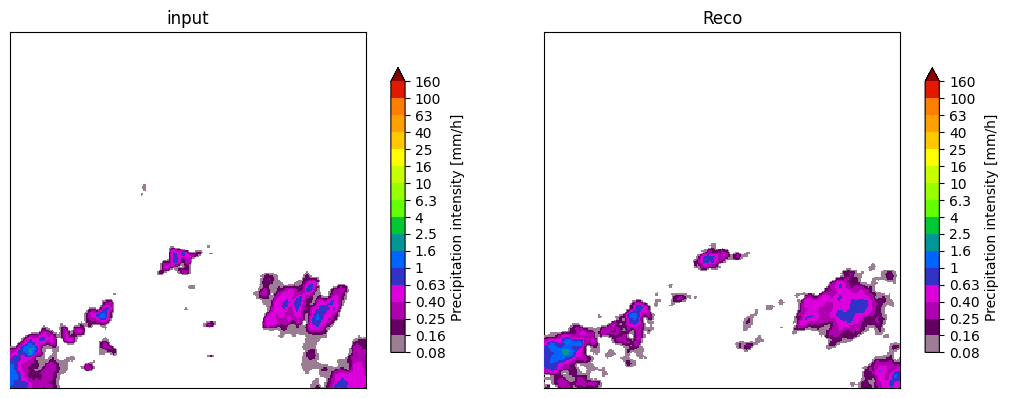

MSE: 0.007 MAE: 0.022 PCC: 0.791 
 CSI(1mm): 0.187 CSI(2mm): nan CSI(8mm): nan 
 FSS(1km): 0.315 FSS(10km): 0.577 FSS(20km): 0.646 FSS(30km): 0.705


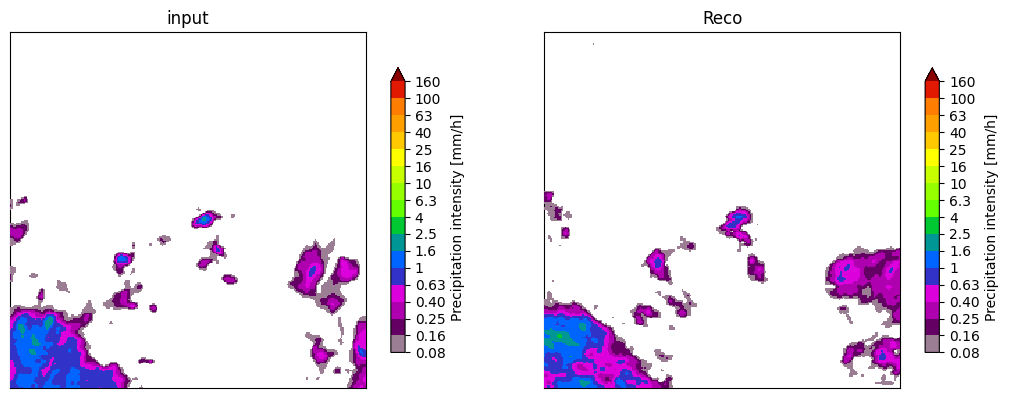

MSE: 0.012 MAE: 0.035 PCC: 0.876 
 CSI(1mm): 0.441 CSI(2mm): 0.0 CSI(8mm): nan 
 FSS(1km): 0.612 FSS(10km): 0.855 FSS(20km): 0.929 FSS(30km): 0.956


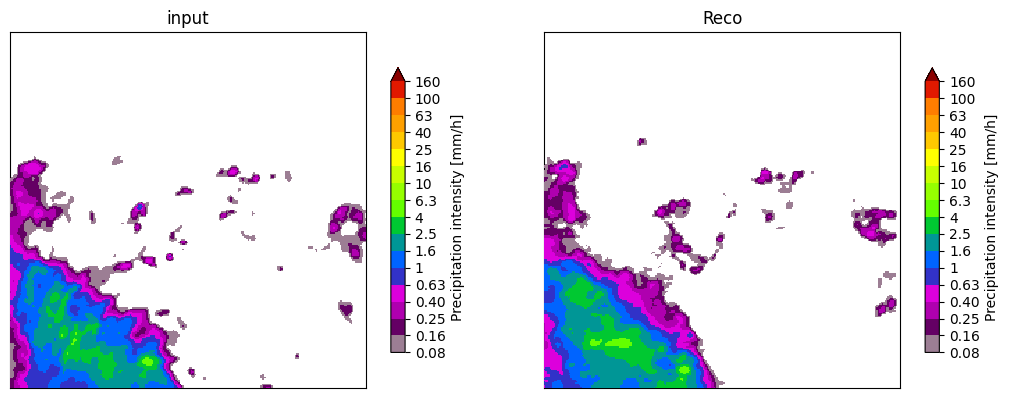

MSE: 0.068 MAE: 0.081 PCC: 0.92 
 CSI(1mm): 0.822 CSI(2mm): 0.482 CSI(8mm): nan 
 FSS(1km): 0.902 FSS(10km): 0.967 FSS(20km): 0.984 FSS(30km): 0.99


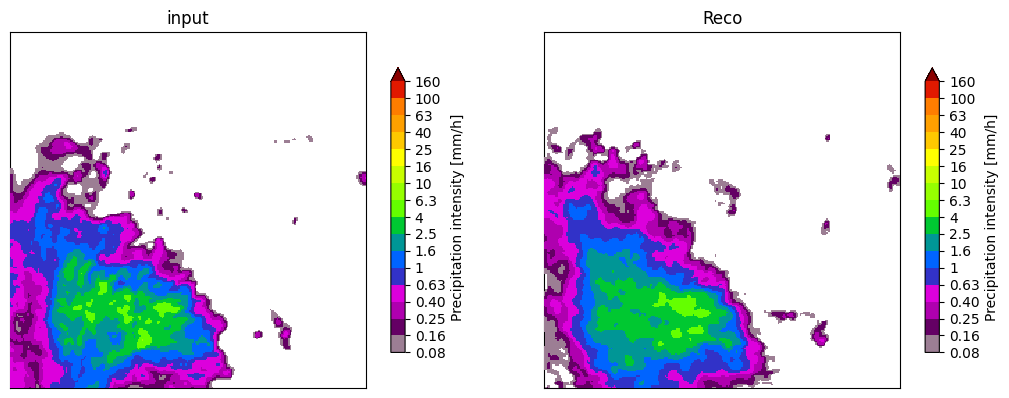

MSE: 0.092 MAE: 0.121 PCC: 0.931 
 CSI(1mm): 0.793 CSI(2mm): 0.681 CSI(8mm): nan 
 FSS(1km): 0.884 FSS(10km): 0.961 FSS(20km): 0.984 FSS(30km): 0.992


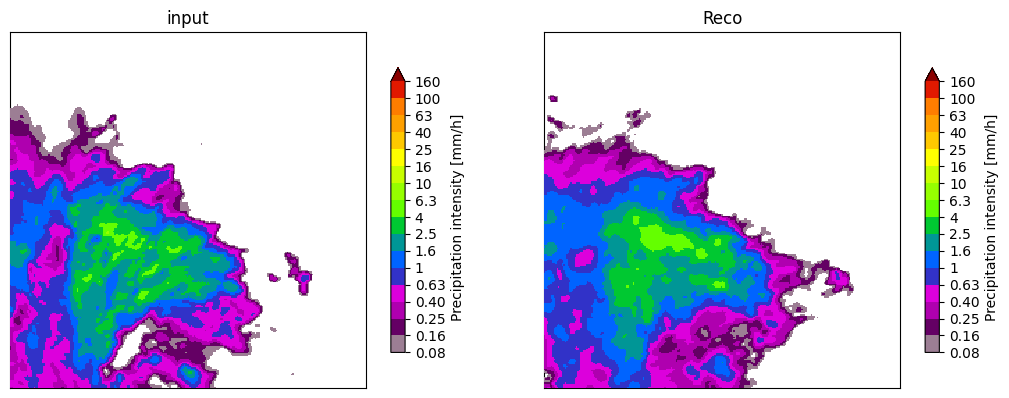

MSE: 0.116 MAE: 0.157 PCC: 0.925 
 CSI(1mm): 0.738 CSI(2mm): 0.595 CSI(8mm): nan 
 FSS(1km): 0.849 FSS(10km): 0.932 FSS(20km): 0.966 FSS(30km): 0.979


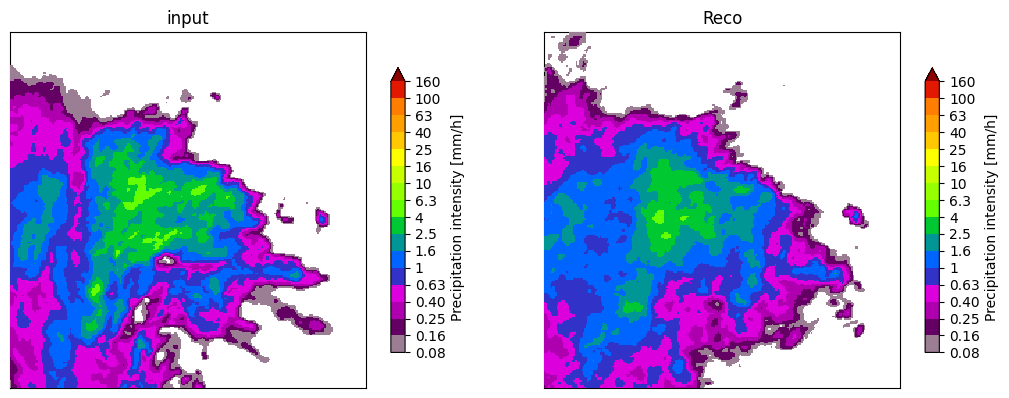

MSE: 0.152 MAE: 0.199 PCC: 0.903 
 CSI(1mm): 0.709 CSI(2mm): 0.495 CSI(8mm): nan 
 FSS(1km): 0.83 FSS(10km): 0.927 FSS(20km): 0.962 FSS(30km): 0.974


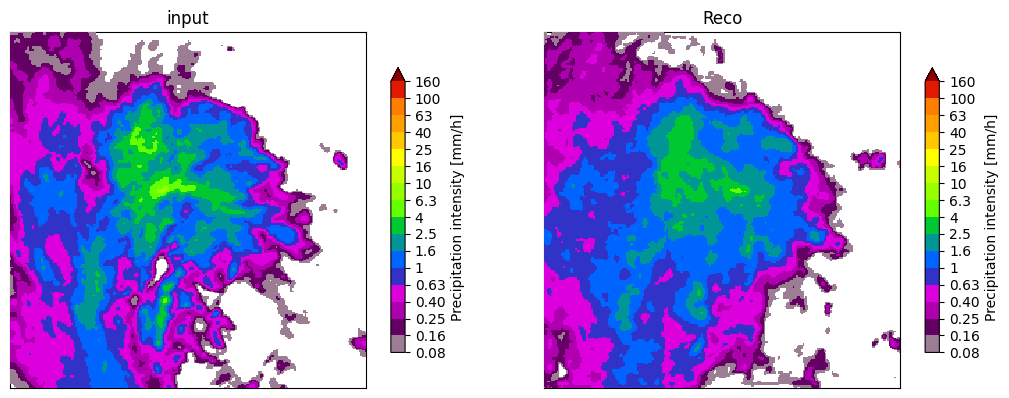

MSE: 0.151 MAE: 0.217 PCC: 0.885 
 CSI(1mm): 0.674 CSI(2mm): 0.489 CSI(8mm): 0.0 
 FSS(1km): 0.805 FSS(10km): 0.915 FSS(20km): 0.957 FSS(30km): 0.975


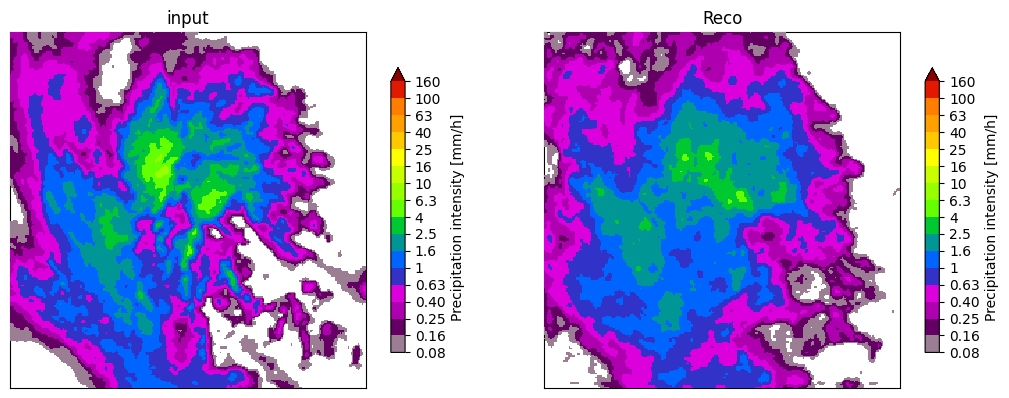

MSE: 0.209 MAE: 0.258 PCC: 0.853 
 CSI(1mm): 0.654 CSI(2mm): 0.391 CSI(8mm): 0.0 
 FSS(1km): 0.791 FSS(10km): 0.901 FSS(20km): 0.946 FSS(30km): 0.963


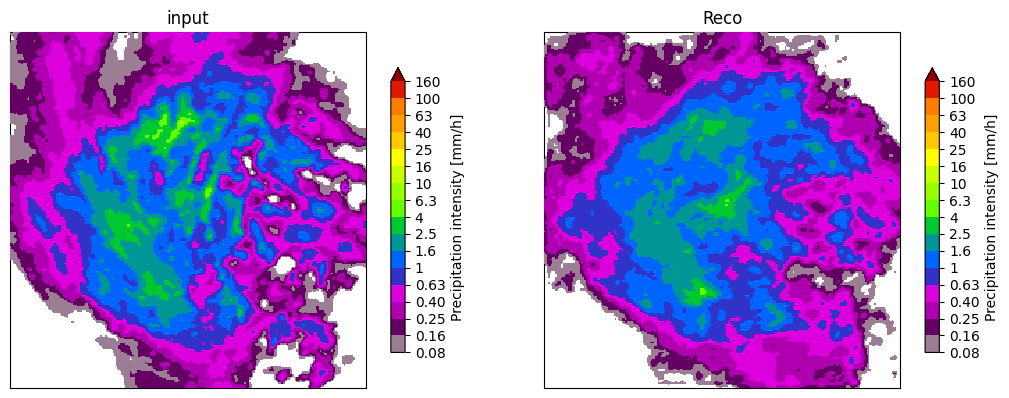

MSE: 0.157 MAE: 0.241 PCC: 0.848 
 CSI(1mm): 0.686 CSI(2mm): 0.339 CSI(8mm): nan 
 FSS(1km): 0.814 FSS(10km): 0.936 FSS(20km): 0.976 FSS(30km): 0.988
input torch.Size([9, 1, 128, 128])
reconstruction torch.Size([9, 1, 128, 128])


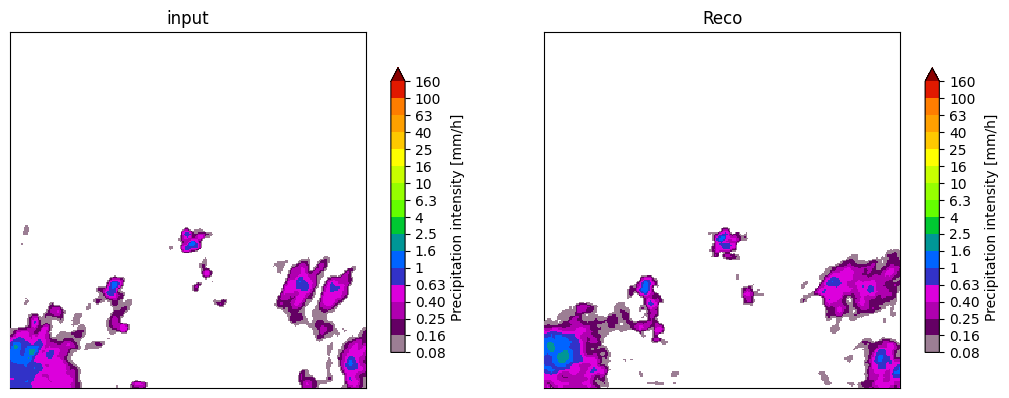

MSE: 0.007 MAE: 0.025 PCC: 0.865 
 CSI(1mm): 0.348 CSI(2mm): 0.0 CSI(8mm): nan 
 FSS(1km): 0.517 FSS(10km): 0.793 FSS(20km): 0.841 FSS(30km): 0.84


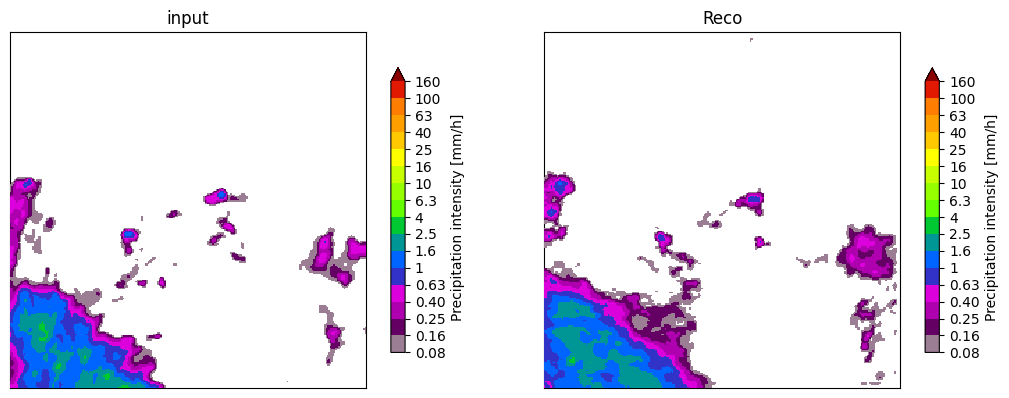

MSE: 0.018 MAE: 0.046 PCC: 0.937 
 CSI(1mm): 0.766 CSI(2mm): 0.158 CSI(8mm): nan 
 FSS(1km): 0.867 FSS(10km): 0.965 FSS(20km): 0.987 FSS(30km): 0.993


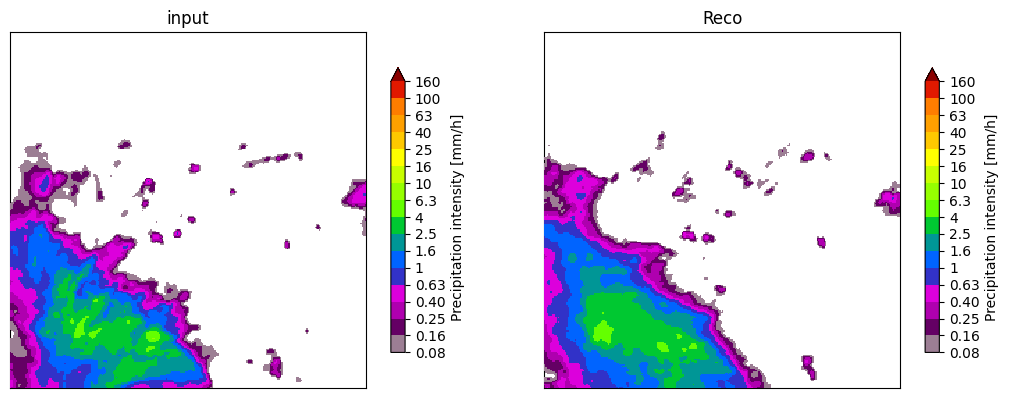

MSE: 0.074 MAE: 0.093 PCC: 0.938 
 CSI(1mm): 0.829 CSI(2mm): 0.668 CSI(8mm): nan 
 FSS(1km): 0.907 FSS(10km): 0.971 FSS(20km): 0.988 FSS(30km): 0.993


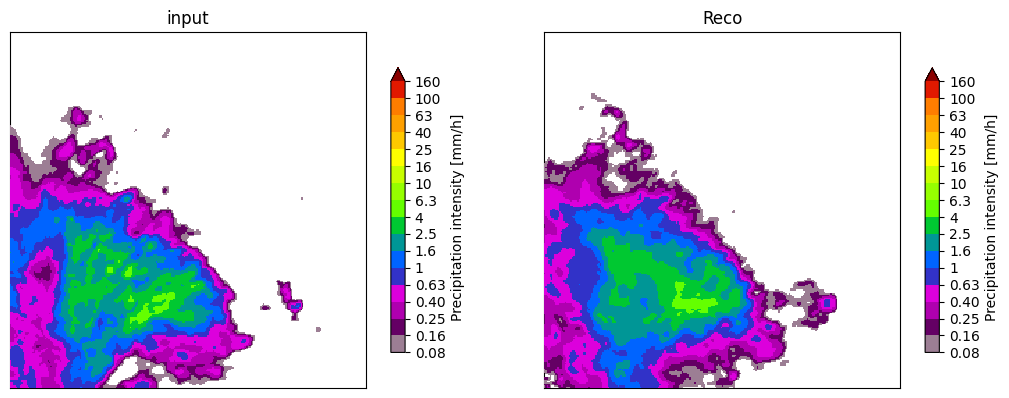

MSE: 0.086 MAE: 0.128 PCC: 0.932 
 CSI(1mm): 0.806 CSI(2mm): 0.608 CSI(8mm): nan 
 FSS(1km): 0.892 FSS(10km): 0.962 FSS(20km): 0.982 FSS(30km): 0.99


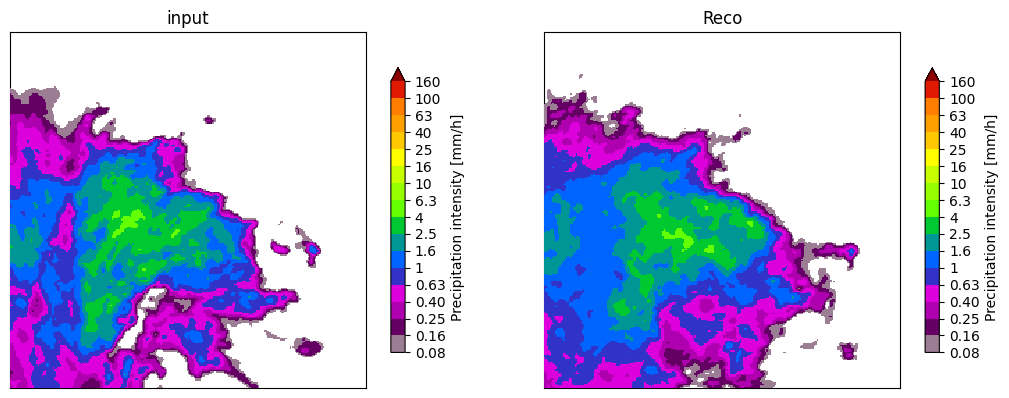

MSE: 0.118 MAE: 0.174 PCC: 0.917 
 CSI(1mm): 0.744 CSI(2mm): 0.552 CSI(8mm): nan 
 FSS(1km): 0.853 FSS(10km): 0.93 FSS(20km): 0.956 FSS(30km): 0.967


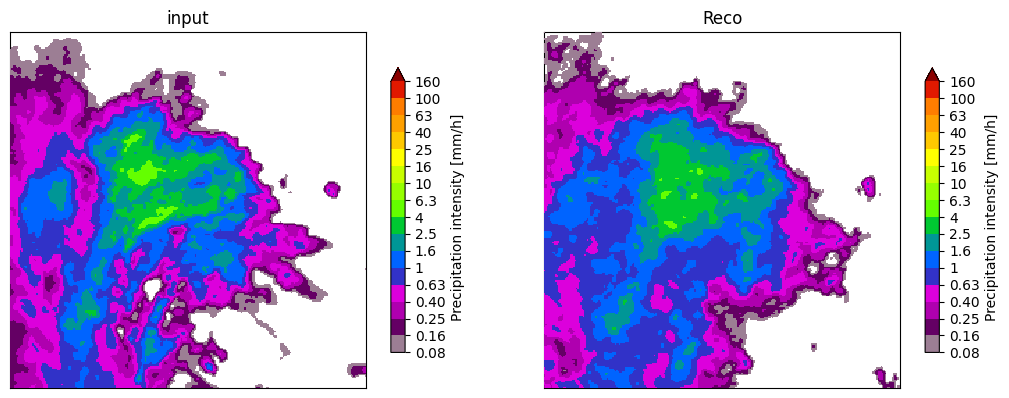

MSE: 0.117 MAE: 0.187 PCC: 0.91 
 CSI(1mm): 0.685 CSI(2mm): 0.593 CSI(8mm): nan 
 FSS(1km): 0.813 FSS(10km): 0.928 FSS(20km): 0.97 FSS(30km): 0.986


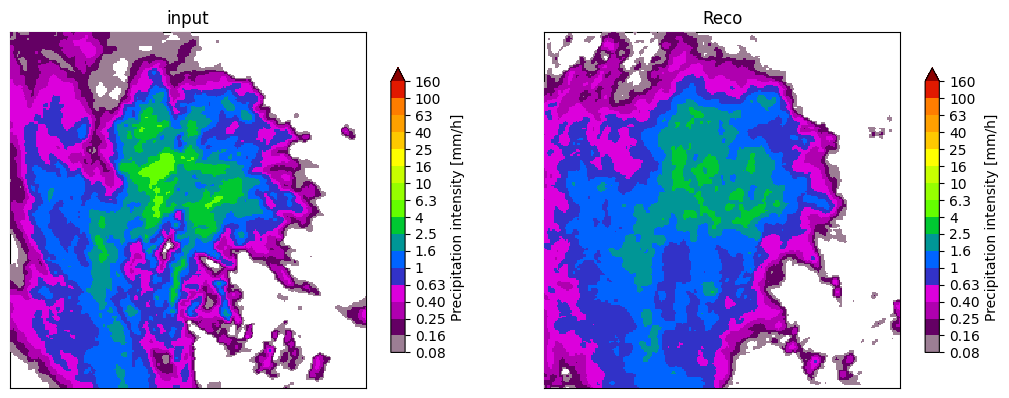

MSE: 0.158 MAE: 0.226 PCC: 0.882 
 CSI(1mm): 0.703 CSI(2mm): 0.482 CSI(8mm): nan 
 FSS(1km): 0.826 FSS(10km): 0.932 FSS(20km): 0.97 FSS(30km): 0.982


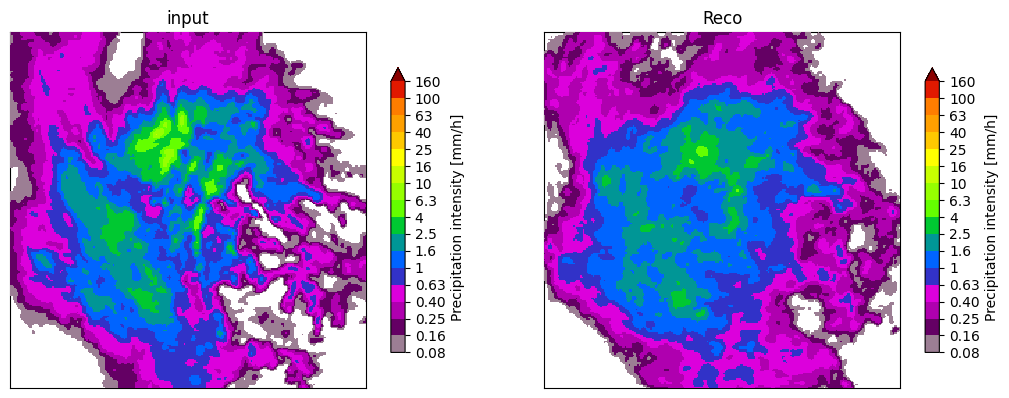

MSE: 0.242 MAE: 0.264 PCC: 0.838 
 CSI(1mm): 0.708 CSI(2mm): 0.397 CSI(8mm): 0.0 
 FSS(1km): 0.829 FSS(10km): 0.929 FSS(20km): 0.964 FSS(30km): 0.976


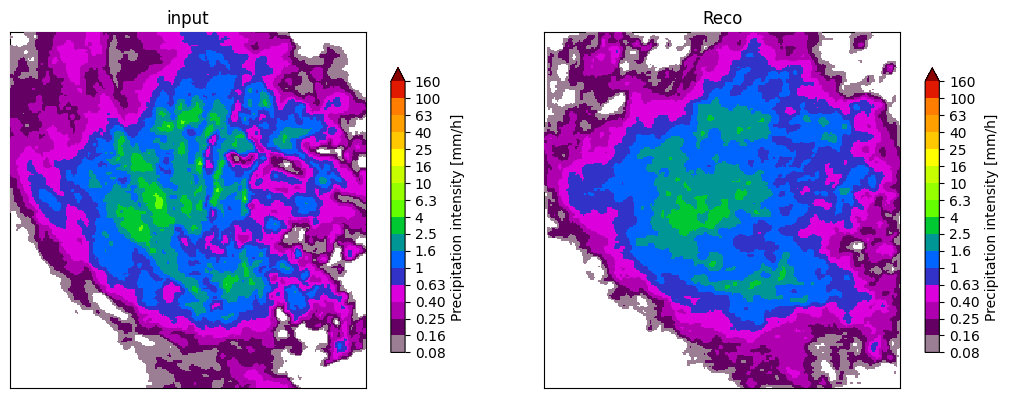

MSE: 0.133 MAE: 0.229 PCC: 0.865 
 CSI(1mm): 0.671 CSI(2mm): 0.342 CSI(8mm): nan 
 FSS(1km): 0.803 FSS(10km): 0.924 FSS(20km): 0.966 FSS(30km): 0.98
input torch.Size([9, 1, 128, 128])
reconstruction torch.Size([9, 1, 128, 128])


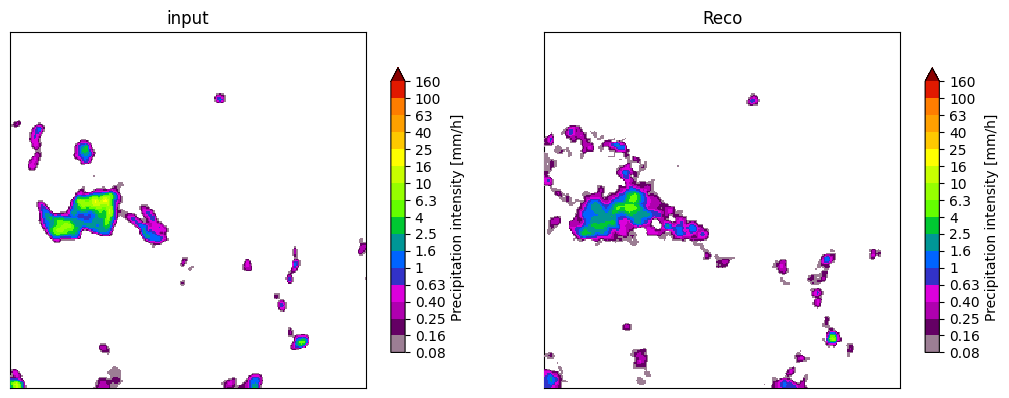

MSE: 0.254 MAE: 0.072 PCC: 0.712 
 CSI(1mm): 0.487 CSI(2mm): 0.378 CSI(8mm): 0.0 
 FSS(1km): 0.655 FSS(10km): 0.875 FSS(20km): 0.946 FSS(30km): 0.967


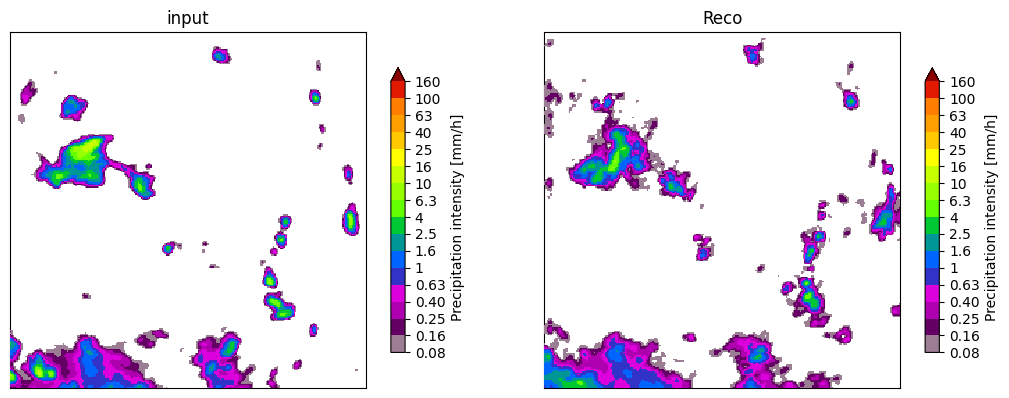

MSE: 0.284 MAE: 0.117 PCC: 0.58 
 CSI(1mm): 0.344 CSI(2mm): 0.185 CSI(8mm): 0.0 
 FSS(1km): 0.512 FSS(10km): 0.737 FSS(20km): 0.868 FSS(30km): 0.912


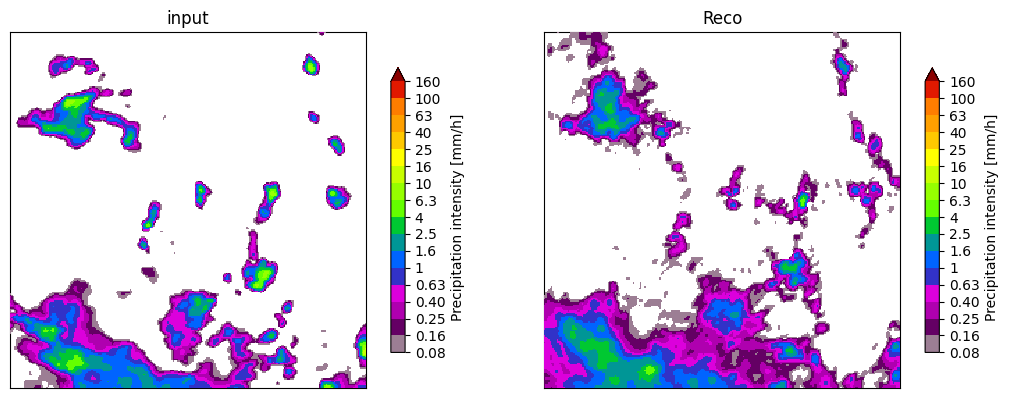

MSE: 0.257 MAE: 0.173 PCC: 0.647 
 CSI(1mm): 0.467 CSI(2mm): 0.225 CSI(8mm): 0.0 
 FSS(1km): 0.637 FSS(10km): 0.84 FSS(20km): 0.922 FSS(30km): 0.949


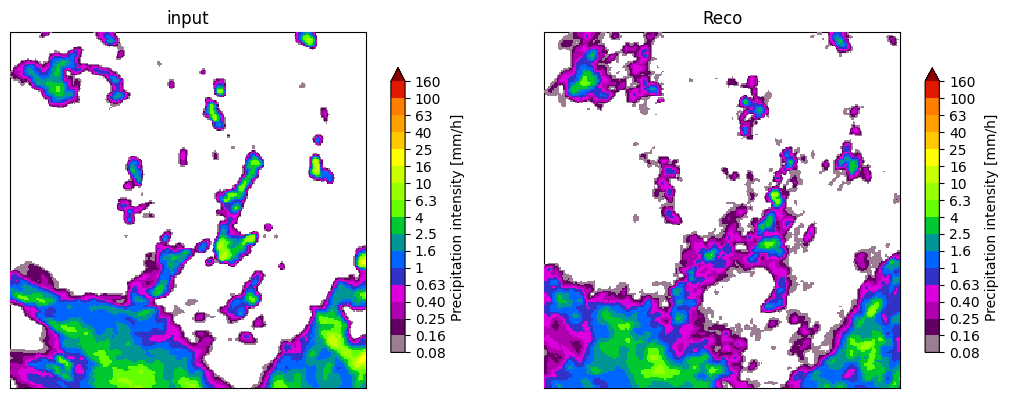

MSE: 1.023 MAE: 0.347 PCC: 0.628 
 CSI(1mm): 0.553 CSI(2mm): 0.399 CSI(8mm): 0.02 
 FSS(1km): 0.712 FSS(10km): 0.865 FSS(20km): 0.927 FSS(30km): 0.946


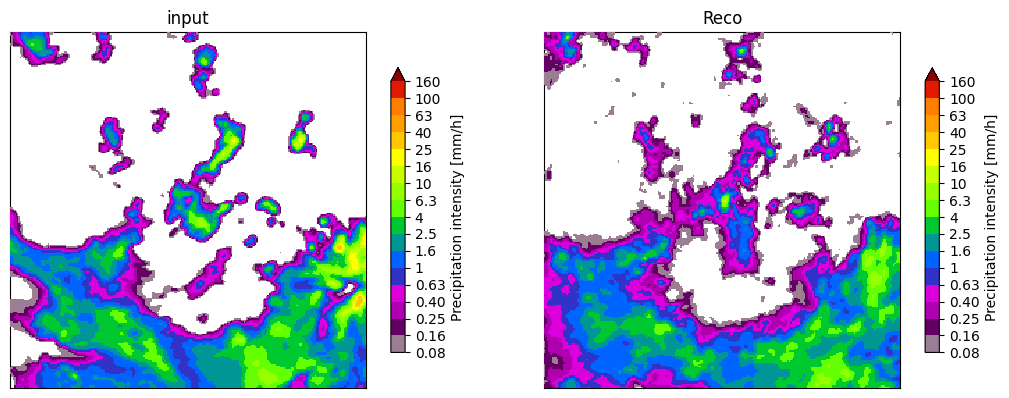

MSE: 2.45 MAE: 0.525 PCC: 0.599 
 CSI(1mm): 0.658 CSI(2mm): 0.468 CSI(8mm): 0.008 
 FSS(1km): 0.794 FSS(10km): 0.904 FSS(20km): 0.949 FSS(30km): 0.97


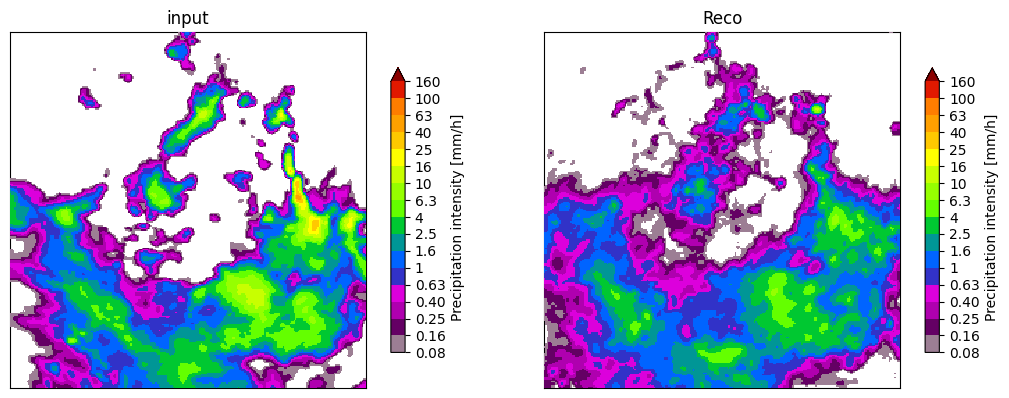

MSE: 3.471 MAE: 0.641 PCC: 0.644 
 CSI(1mm): 0.67 CSI(2mm): 0.471 CSI(8mm): 0.001 
 FSS(1km): 0.802 FSS(10km): 0.918 FSS(20km): 0.966 FSS(30km): 0.982


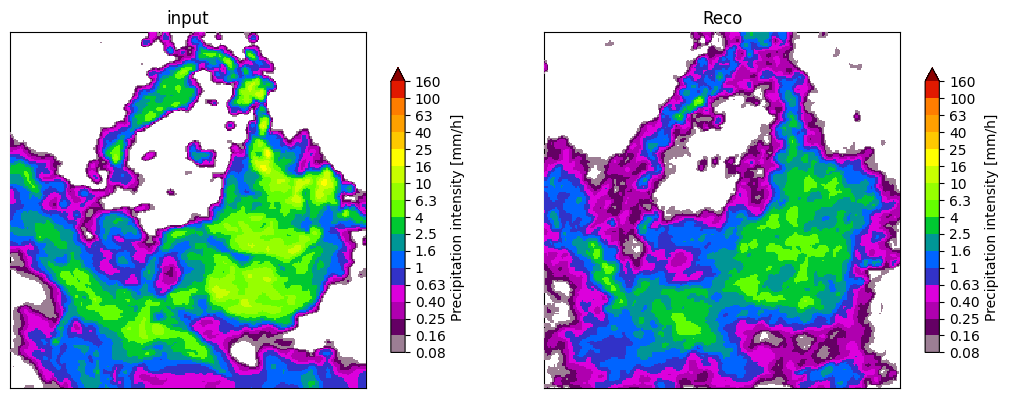

MSE: 2.563 MAE: 0.778 PCC: 0.767 
 CSI(1mm): 0.644 CSI(2mm): 0.54 CSI(8mm): 0.0 
 FSS(1km): 0.783 FSS(10km): 0.895 FSS(20km): 0.945 FSS(30km): 0.964


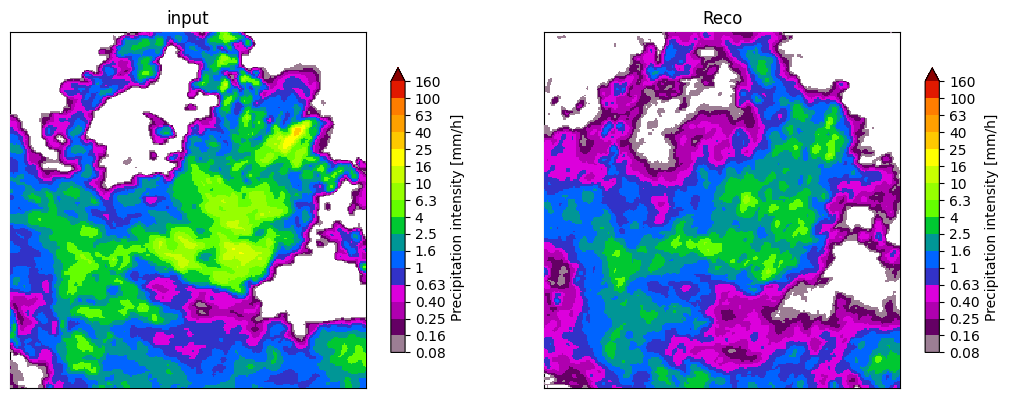

MSE: 3.179 MAE: 0.865 PCC: 0.744 
 CSI(1mm): 0.645 CSI(2mm): 0.459 CSI(8mm): 0.0 
 FSS(1km): 0.784 FSS(10km): 0.881 FSS(20km): 0.924 FSS(30km): 0.943


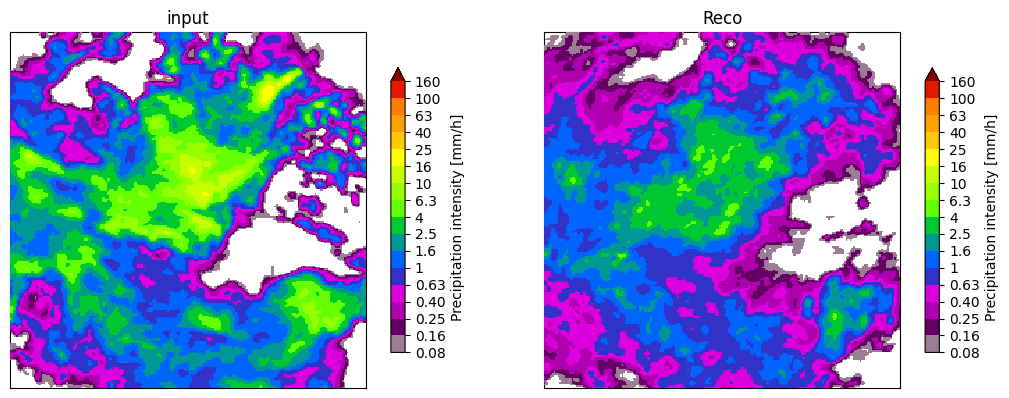

MSE: 3.921 MAE: 1.045 PCC: 0.73 
 CSI(1mm): 0.567 CSI(2mm): 0.368 CSI(8mm): 0.0 
 FSS(1km): 0.723 FSS(10km): 0.828 FSS(20km): 0.874 FSS(30km): 0.894
input torch.Size([9, 1, 128, 128])
reconstruction torch.Size([9, 1, 128, 128])


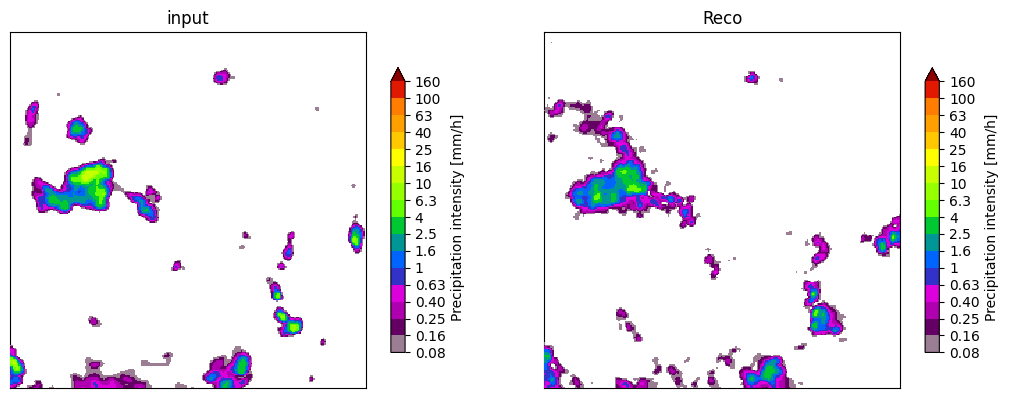

MSE: 0.245 MAE: 0.087 PCC: 0.642 
 CSI(1mm): 0.436 CSI(2mm): 0.266 CSI(8mm): 0.0 
 FSS(1km): 0.607 FSS(10km): 0.86 FSS(20km): 0.947 FSS(30km): 0.97


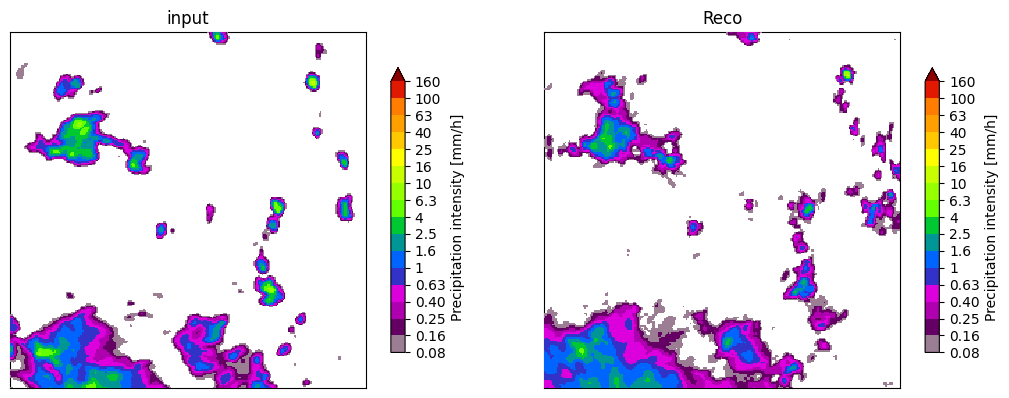

MSE: 0.182 MAE: 0.121 PCC: 0.671 
 CSI(1mm): 0.462 CSI(2mm): 0.227 CSI(8mm): 0.0 
 FSS(1km): 0.632 FSS(10km): 0.847 FSS(20km): 0.925 FSS(30km): 0.945


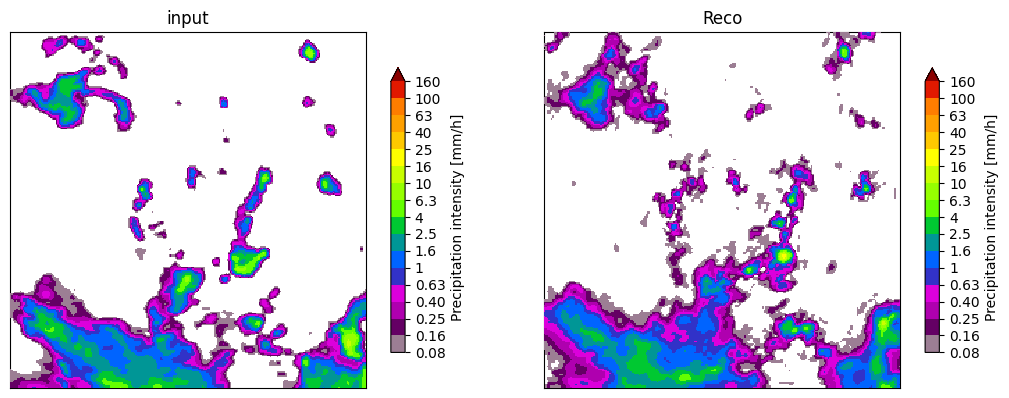

MSE: 0.448 MAE: 0.228 PCC: 0.646 
 CSI(1mm): 0.564 CSI(2mm): 0.274 CSI(8mm): 0.0 
 FSS(1km): 0.721 FSS(10km): 0.898 FSS(20km): 0.96 FSS(30km): 0.978


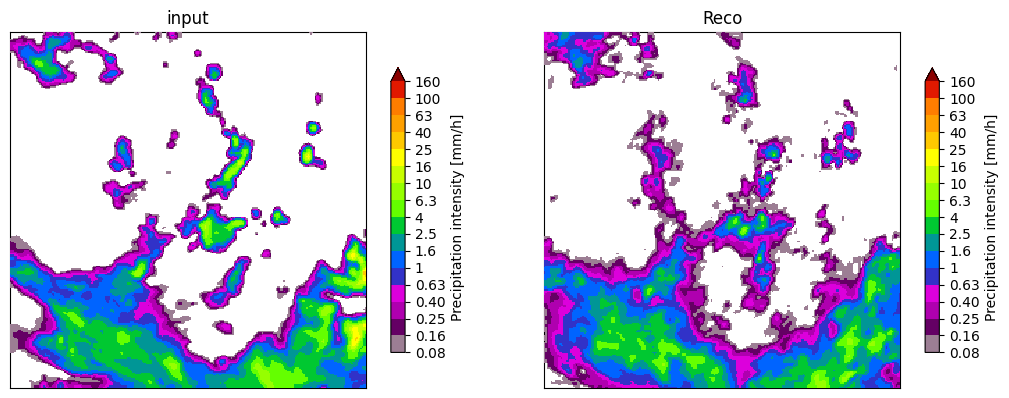

MSE: 1.497 MAE: 0.41 PCC: 0.631 
 CSI(1mm): 0.652 CSI(2mm): 0.511 CSI(8mm): 0.0 
 FSS(1km): 0.79 FSS(10km): 0.914 FSS(20km): 0.96 FSS(30km): 0.977


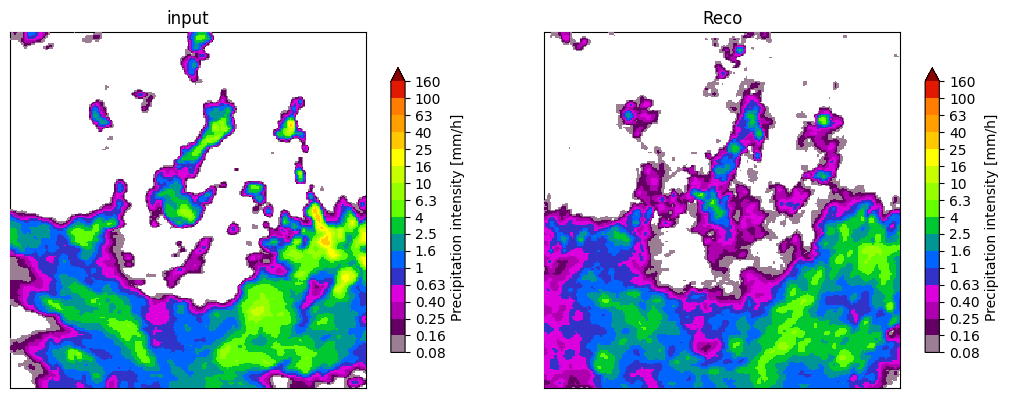

MSE: 3.094 MAE: 0.601 PCC: 0.625 
 CSI(1mm): 0.676 CSI(2mm): 0.498 CSI(8mm): 0.003 
 FSS(1km): 0.807 FSS(10km): 0.915 FSS(20km): 0.957 FSS(30km): 0.973


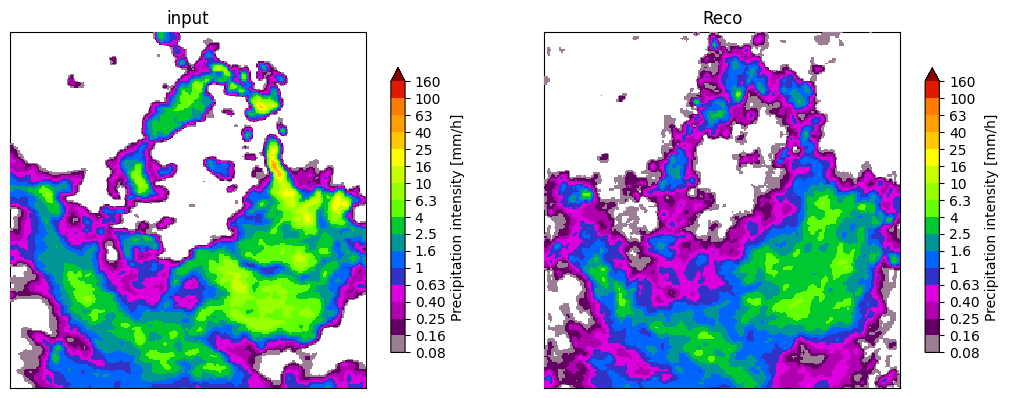

MSE: 3.853 MAE: 0.736 PCC: 0.649 
 CSI(1mm): 0.661 CSI(2mm): 0.508 CSI(8mm): 0.0 
 FSS(1km): 0.796 FSS(10km): 0.899 FSS(20km): 0.941 FSS(30km): 0.958


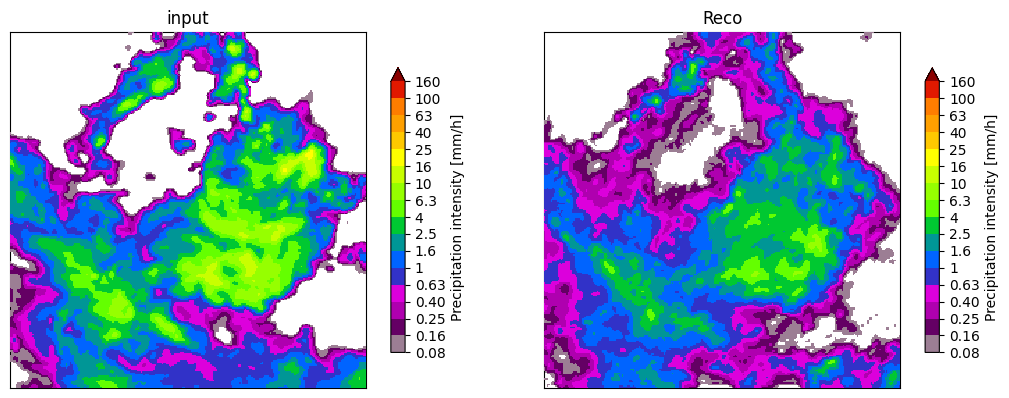

MSE: 2.618 MAE: 0.8 PCC: 0.787 
 CSI(1mm): 0.673 CSI(2mm): 0.489 CSI(8mm): 0.0 
 FSS(1km): 0.805 FSS(10km): 0.908 FSS(20km): 0.948 FSS(30km): 0.962


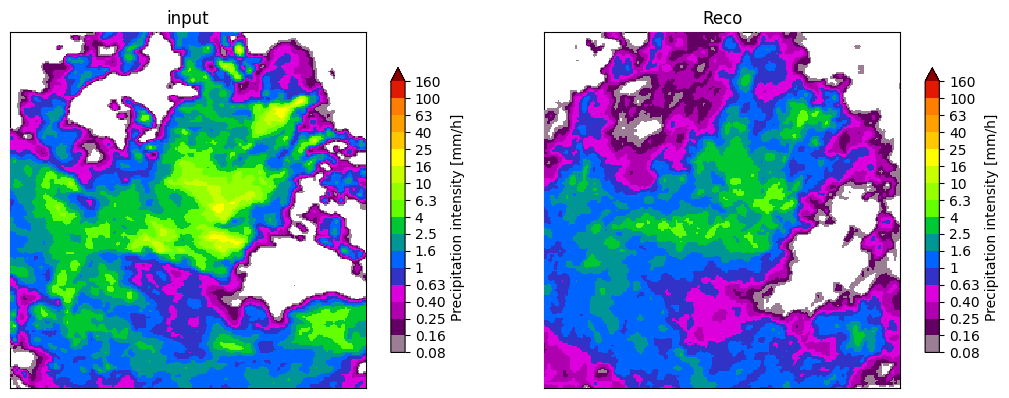

MSE: 3.611 MAE: 0.96 PCC: 0.731 
 CSI(1mm): 0.639 CSI(2mm): 0.367 CSI(8mm): 0.0 
 FSS(1km): 0.779 FSS(10km): 0.875 FSS(20km): 0.918 FSS(30km): 0.936


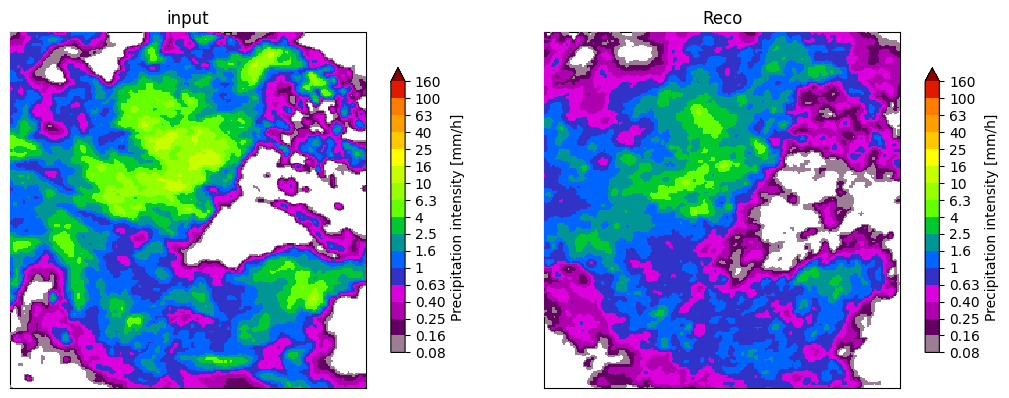

MSE: 2.716 MAE: 0.887 PCC: 0.761 
 CSI(1mm): 0.596 CSI(2mm): 0.397 CSI(8mm): 0.0 
 FSS(1km): 0.747 FSS(10km): 0.861 FSS(20km): 0.912 FSS(30km): 0.934
input torch.Size([9, 1, 128, 128])
reconstruction torch.Size([9, 1, 128, 128])


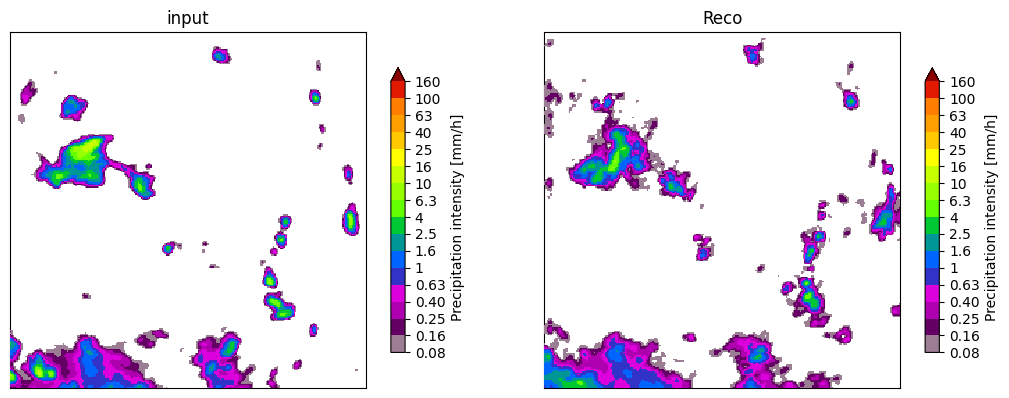

MSE: 0.284 MAE: 0.117 PCC: 0.58 
 CSI(1mm): 0.344 CSI(2mm): 0.185 CSI(8mm): 0.0 
 FSS(1km): 0.512 FSS(10km): 0.737 FSS(20km): 0.868 FSS(30km): 0.912


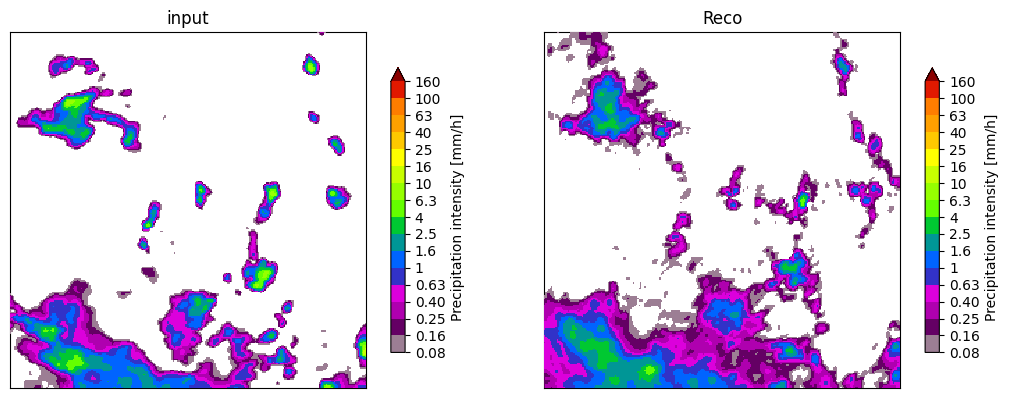

MSE: 0.257 MAE: 0.173 PCC: 0.647 
 CSI(1mm): 0.467 CSI(2mm): 0.225 CSI(8mm): 0.0 
 FSS(1km): 0.637 FSS(10km): 0.84 FSS(20km): 0.922 FSS(30km): 0.949


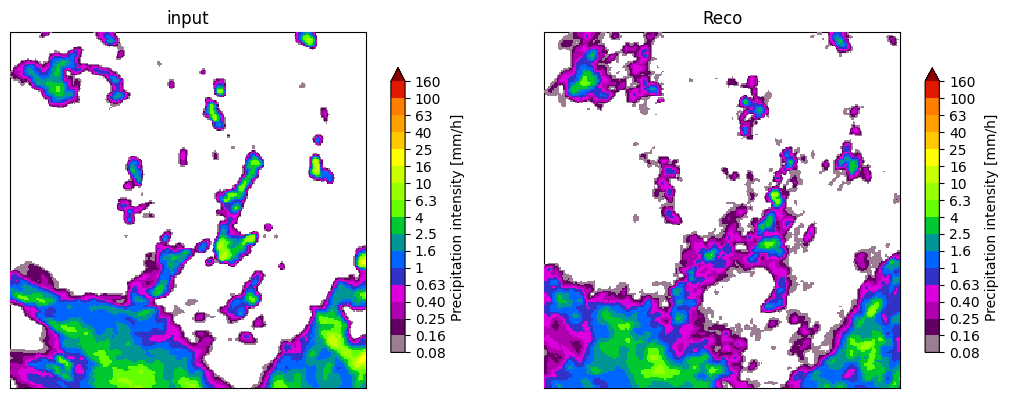

MSE: 1.023 MAE: 0.347 PCC: 0.628 
 CSI(1mm): 0.553 CSI(2mm): 0.399 CSI(8mm): 0.02 
 FSS(1km): 0.712 FSS(10km): 0.865 FSS(20km): 0.927 FSS(30km): 0.946


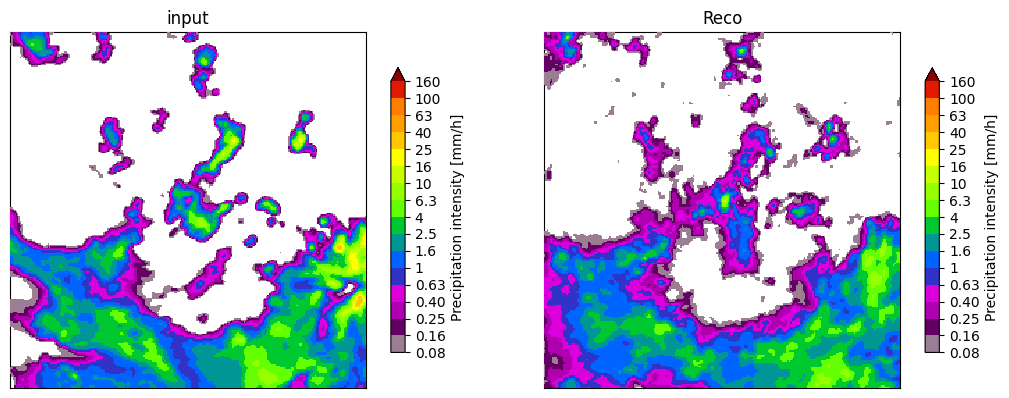

MSE: 2.45 MAE: 0.525 PCC: 0.599 
 CSI(1mm): 0.658 CSI(2mm): 0.468 CSI(8mm): 0.008 
 FSS(1km): 0.794 FSS(10km): 0.904 FSS(20km): 0.949 FSS(30km): 0.97


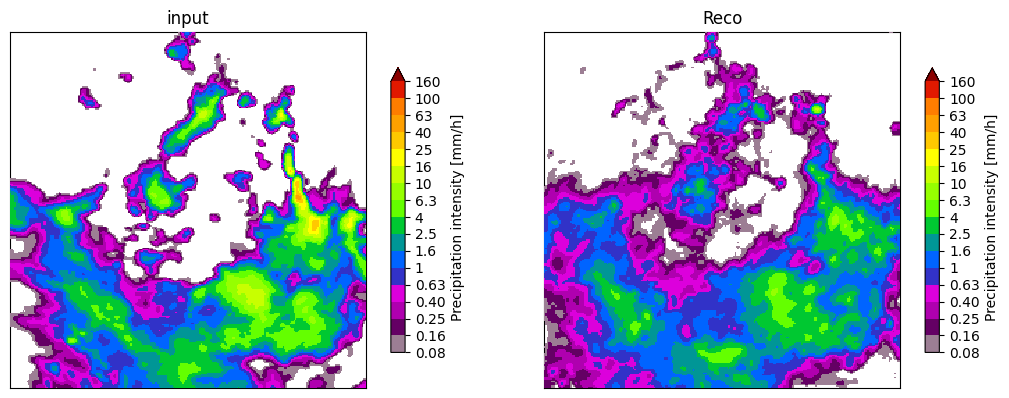

MSE: 3.471 MAE: 0.641 PCC: 0.644 
 CSI(1mm): 0.67 CSI(2mm): 0.471 CSI(8mm): 0.001 
 FSS(1km): 0.802 FSS(10km): 0.918 FSS(20km): 0.966 FSS(30km): 0.982


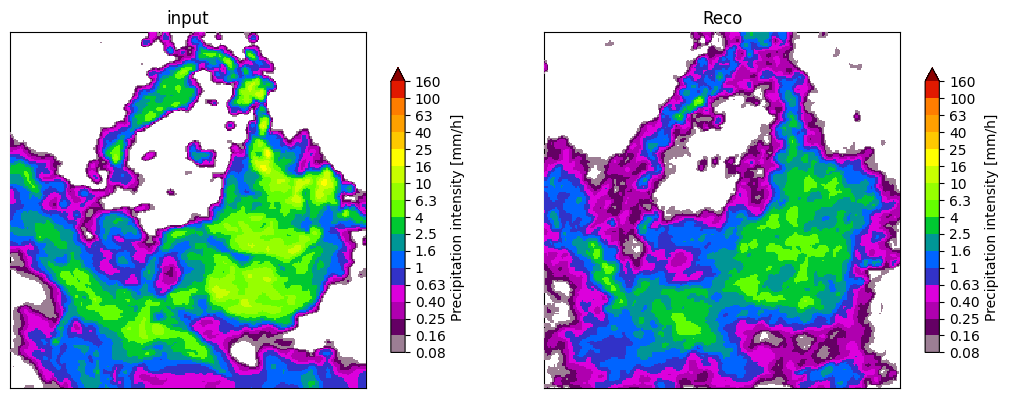

MSE: 2.563 MAE: 0.778 PCC: 0.767 
 CSI(1mm): 0.644 CSI(2mm): 0.54 CSI(8mm): 0.0 
 FSS(1km): 0.783 FSS(10km): 0.895 FSS(20km): 0.945 FSS(30km): 0.964


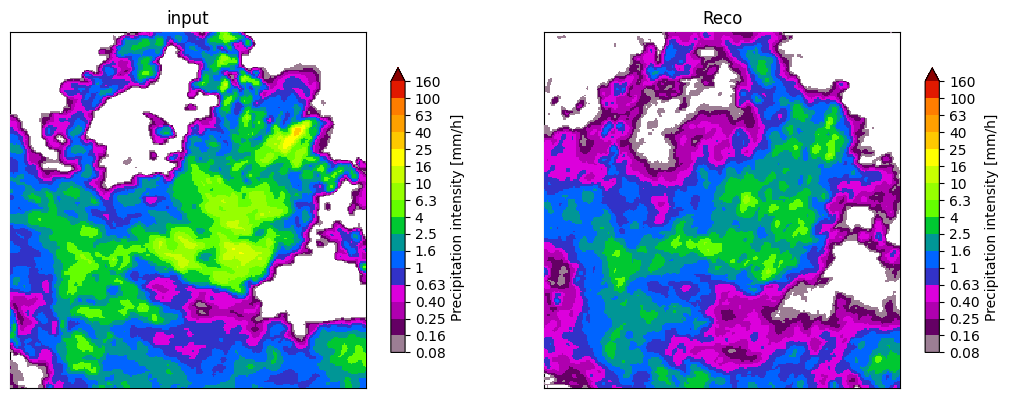

MSE: 3.179 MAE: 0.865 PCC: 0.744 
 CSI(1mm): 0.645 CSI(2mm): 0.459 CSI(8mm): 0.0 
 FSS(1km): 0.784 FSS(10km): 0.881 FSS(20km): 0.924 FSS(30km): 0.943


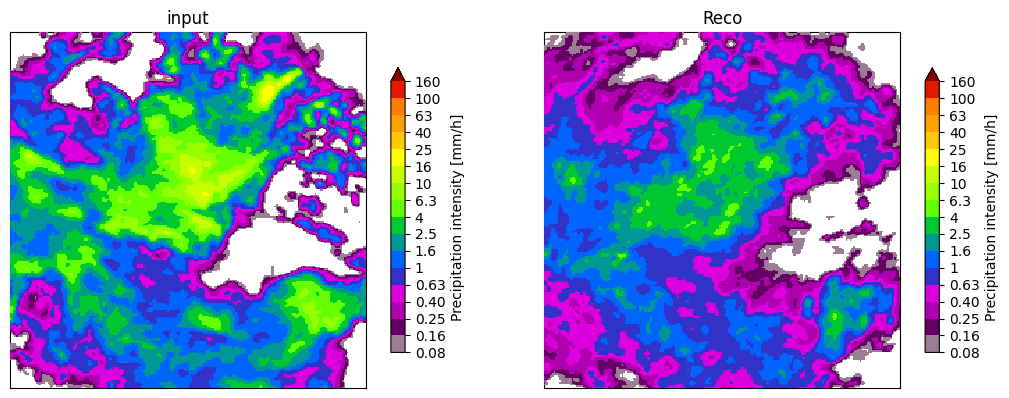

MSE: 3.921 MAE: 1.045 PCC: 0.73 
 CSI(1mm): 0.567 CSI(2mm): 0.368 CSI(8mm): 0.0 
 FSS(1km): 0.723 FSS(10km): 0.828 FSS(20km): 0.874 FSS(30km): 0.894


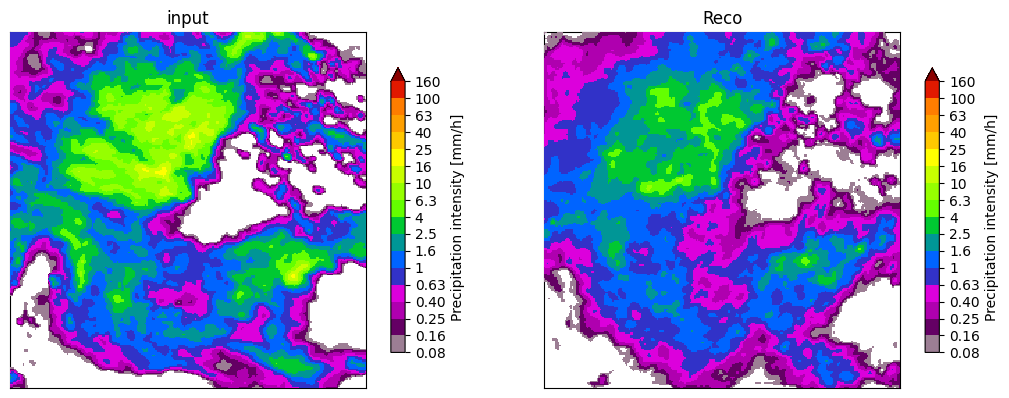

MSE: 3.294 MAE: 0.901 PCC: 0.789 
 CSI(1mm): 0.639 CSI(2mm): 0.443 CSI(8mm): 0.0 
 FSS(1km): 0.78 FSS(10km): 0.89 FSS(20km): 0.931 FSS(30km): 0.948
input torch.Size([9, 1, 128, 128])
reconstruction torch.Size([9, 1, 128, 128])


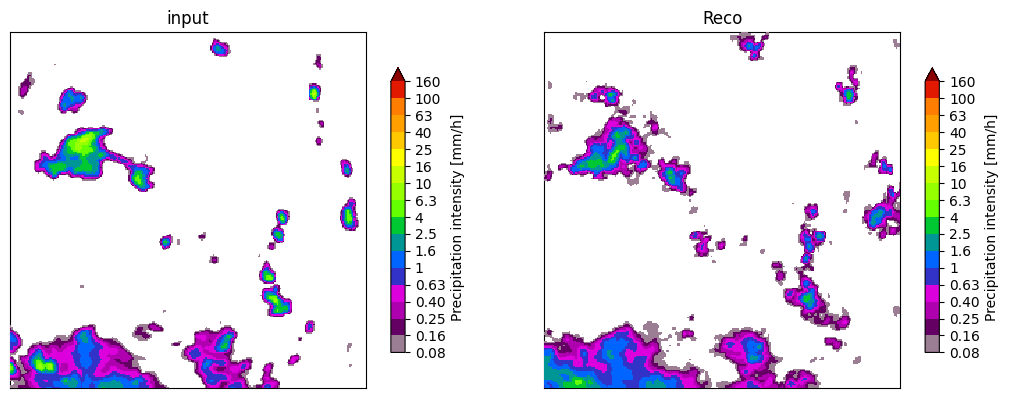

MSE: 0.234 MAE: 0.117 PCC: 0.604 
 CSI(1mm): 0.34 CSI(2mm): 0.165 CSI(8mm): 0.0 
 FSS(1km): 0.507 FSS(10km): 0.716 FSS(20km): 0.83 FSS(30km): 0.882


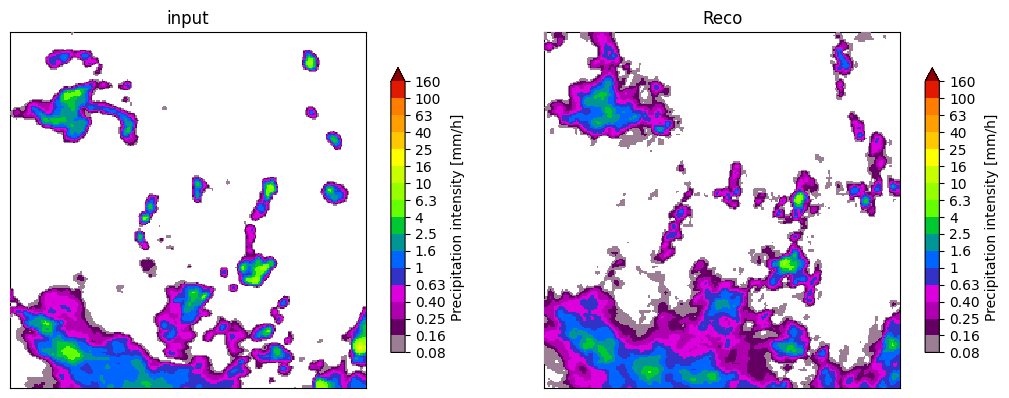

MSE: 0.35 MAE: 0.19 PCC: 0.6 
 CSI(1mm): 0.448 CSI(2mm): 0.176 CSI(8mm): 0.0 
 FSS(1km): 0.619 FSS(10km): 0.846 FSS(20km): 0.936 FSS(30km): 0.966


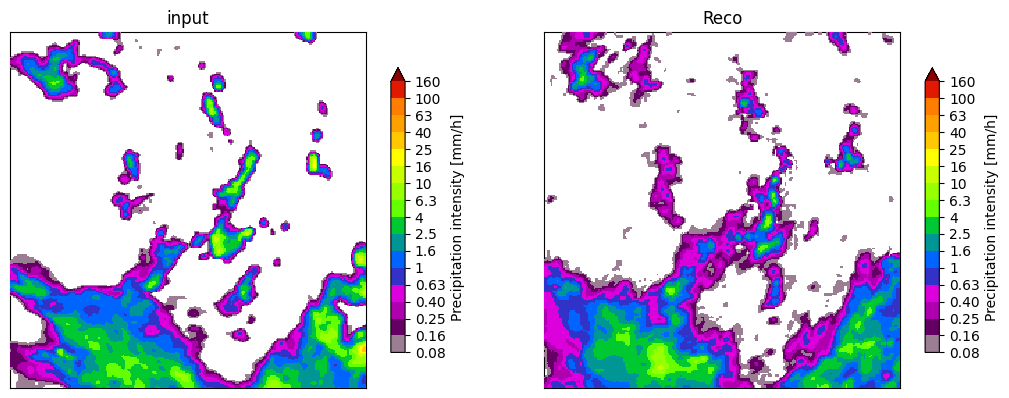

MSE: 1.186 MAE: 0.356 PCC: 0.615 
 CSI(1mm): 0.623 CSI(2mm): 0.444 CSI(8mm): 0.0 
 FSS(1km): 0.767 FSS(10km): 0.907 FSS(20km): 0.956 FSS(30km): 0.973


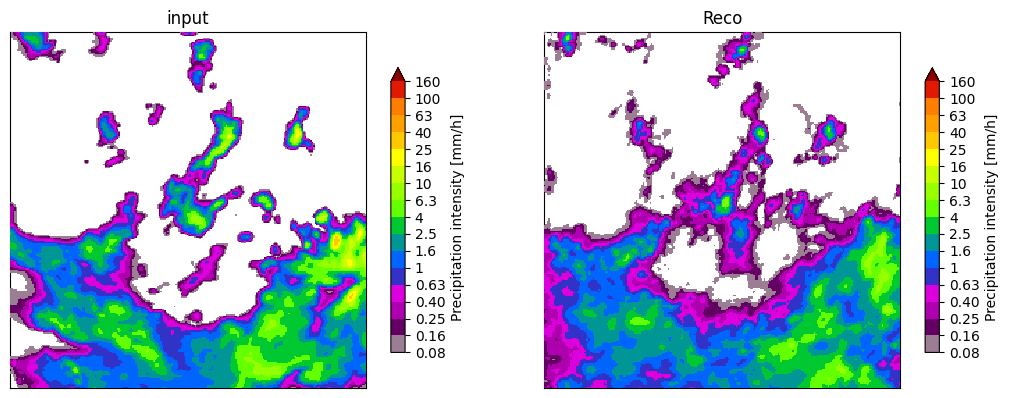

MSE: 2.042 MAE: 0.517 PCC: 0.648 
 CSI(1mm): 0.696 CSI(2mm): 0.496 CSI(8mm): 0.019 
 FSS(1km): 0.821 FSS(10km): 0.923 FSS(20km): 0.962 FSS(30km): 0.977


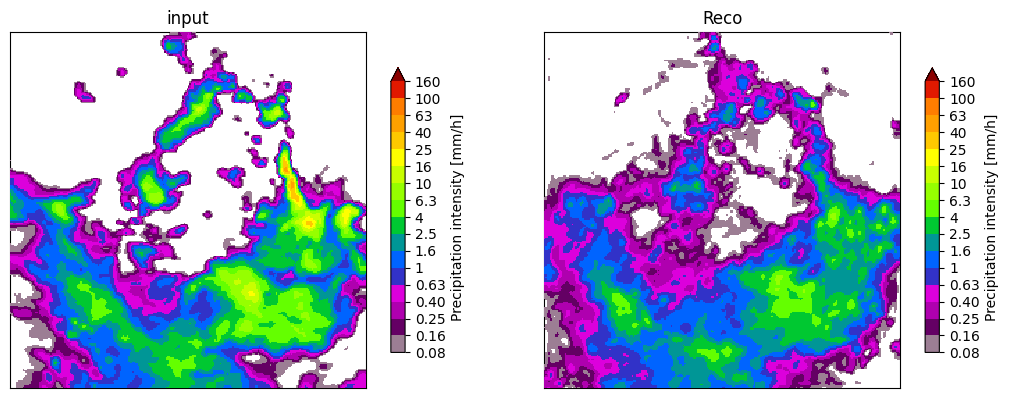

MSE: 4.259 MAE: 0.681 PCC: 0.619 
 CSI(1mm): 0.663 CSI(2mm): 0.491 CSI(8mm): 0.0 
 FSS(1km): 0.797 FSS(10km): 0.908 FSS(20km): 0.954 FSS(30km): 0.972


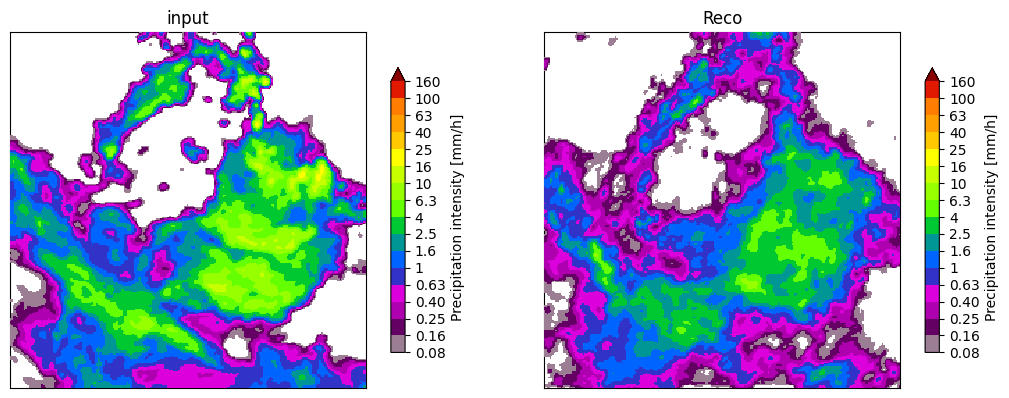

MSE: 2.396 MAE: 0.765 PCC: 0.775 
 CSI(1mm): 0.642 CSI(2mm): 0.517 CSI(8mm): 0.004 
 FSS(1km): 0.782 FSS(10km): 0.894 FSS(20km): 0.94 FSS(30km): 0.958


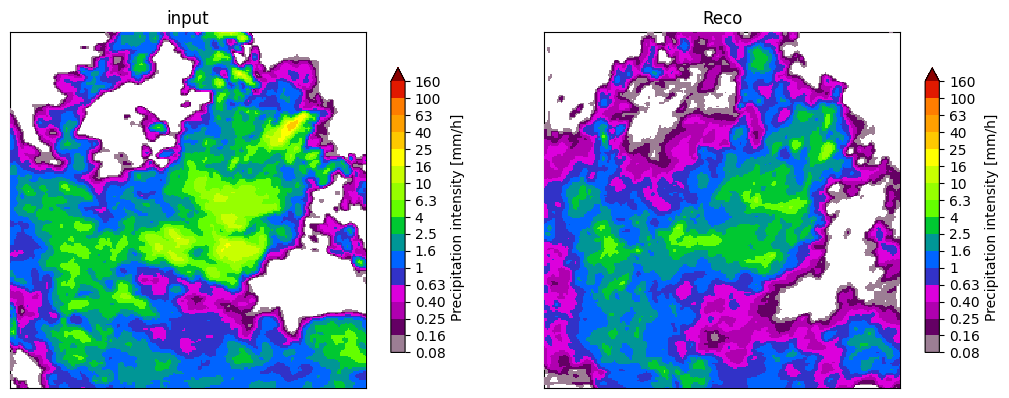

MSE: 3.847 MAE: 0.948 PCC: 0.696 
 CSI(1mm): 0.624 CSI(2mm): 0.395 CSI(8mm): 0.0 
 FSS(1km): 0.768 FSS(10km): 0.865 FSS(20km): 0.912 FSS(30km): 0.933


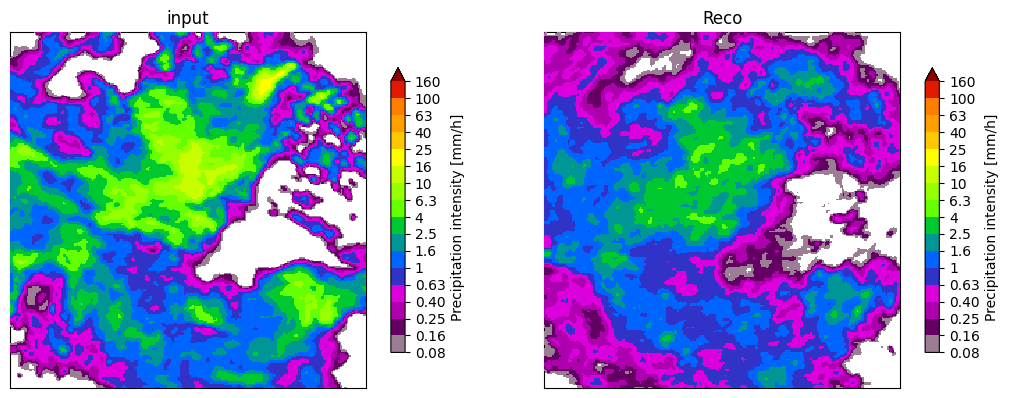

MSE: 3.614 MAE: 1.012 PCC: 0.749 
 CSI(1mm): 0.575 CSI(2mm): 0.373 CSI(8mm): 0.0 
 FSS(1km): 0.73 FSS(10km): 0.837 FSS(20km): 0.887 FSS(30km): 0.908


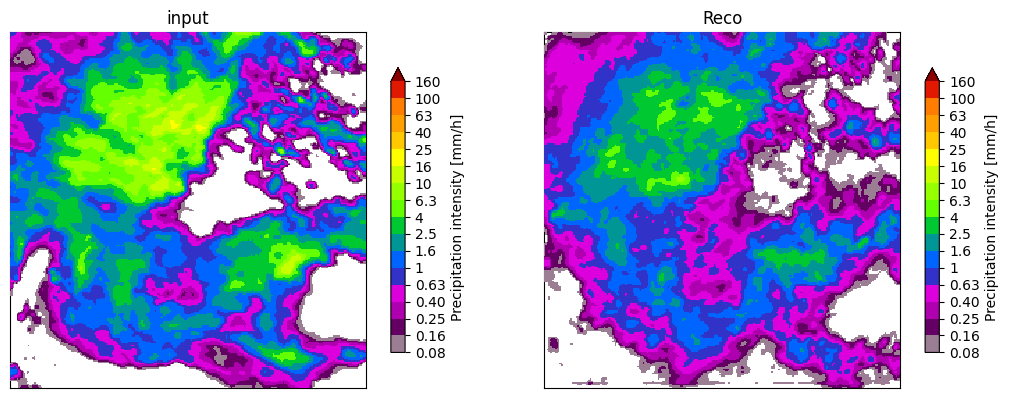

MSE: 3.414 MAE: 0.926 PCC: 0.803 
 CSI(1mm): 0.638 CSI(2mm): 0.448 CSI(8mm): 0.0 
 FSS(1km): 0.779 FSS(10km): 0.877 FSS(20km): 0.915 FSS(30km): 0.93


In [8]:
import time
import matplotlib.pyplot as plt
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
from einops import rearrange, repeat
import math
import numpy as np
pcc_sum = [0]*6
mse_sum = [0]*6
mae_sum = [0]*6
csi1_sum = [0]*6
csi2_sum = [0]*6
csi8_sum = [0]*6
far1_sum = [0]*6
far2_sum = [0]*6
far8_sum = [0]*6
fss1_sum = [0]*6
fss10_sum = [0]*6
fss20_sum = [0]*6
fss30_sum = [0]*6
count_csi1 = [0] * 6
count_csi2 = [0] * 6
count_csi8 = [0] * 6
count_far1 = [0] * 6
count_far2 = [0] * 6
count_far8 = [0] * 6
count_fss1 = [0] * 6
count_fss10 = [0] * 6
count_fss20 = [0] * 6
count_fss30 = [0] * 6

record = {}
count = 0
j = 0
tokenizer=tokenizer.to(device)

for i, images in enumerate(loaders['ext']):
    if i>5:
       break
    image = images[0].unsqueeze(1).unsqueeze(0)
    observation = rearrange(image, 'b t c h w  -> (b t) c h w')
    image = observation
    input_image = image.to(device="cuda:1")
    print("input", input_image.size())
    reco = tokenizer.encode_decode(input_image,should_preprocess = True, should_postprocess= True)
    print("reconstruction", reco.size())
    image = F.interpolate(image, size=(256, 256), mode='bilinear', align_corners=False)
    reco = F.interpolate(reco, size=(256, 256), mode='bilinear', align_corners=False)
    for t in range(9):
         a1_display = image[t,0,:,:].to('cpu').detach().numpy()*40
         a_p1_display =reco[t,0,:,:].to('cpu').detach().numpy()*40
         a_p1_display[a_p1_display<0.1]= 0.0
         plt.figure(figsize=(16, 4))
         plt.subplot(131)
         plot_precip_field(a1_display, title="input", axis='off')
         plt.subplot(132)
         plot_precip_field(a_p1_display, title="Reco")
         plt.tight_layout()
         plt.show()
         if not np.isnan(a_p1_display).any() and not np.isnan(a1_display).any():
            scores_cont1 = det_cont_fct(a_p1_display, a1_display, thr=0)
            scores_cat1 = det_cat_fct(a_p1_display, a1_display, 1)
            scores_cat2 = det_cat_fct(a_p1_display, a1_display, 2)
            scores_cat8 = det_cat_fct(a_p1_display, a1_display, 8)
            scores_spatial = intensity_scale(a_p1_display, a1_display, 'FSS', 1, [1,10,20,30])

            print( 
                  'MSE:', np.around(scores_cont1['MSE'],3), 
                  'MAE:', np.around(scores_cont1['MAE'],3), 
                  'PCC:', np.around(scores_cont1['corr_p'],3),'\n', 
                  'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
                  'CSI(2mm):', np.around(scores_cat2['CSI'],3),
                  'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
                  'FSS(1km):', np.around(scores_spatial[3][0],3),
                  'FSS(10km):', np.around(scores_spatial[2][0],3),
                  'FSS(20km):', np.around(scores_spatial[1][0],3),
                  'FSS(30km):', np.around(scores_spatial[0][0],3)
                  )

In [ ]:
import time
import matplotlib.pyplot as plt
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
from einops import rearrange, repeat
import math
import numpy as np
pcc_sum = [0]*6
mse_sum = [0]*6
mae_sum = [0]*6
csi1_sum = [0]*6
csi2_sum = [0]*6
csi8_sum = [0]*6
far1_sum = [0]*6
far2_sum = [0]*6
far8_sum = [0]*6
fss1_sum = [0]*6
fss10_sum = [0]*6
fss20_sum = [0]*6
fss30_sum = [0]*6
count_csi1 = [0] * 6
count_csi2 = [0] * 6
count_csi8 = [0] * 6
count_far1 = [0] * 6
count_far2 = [0] * 6
count_far8 = [0] * 6
count_fss1 = [0] * 6
count_fss10 = [0] * 6
count_fss20 = [0] * 6
count_fss30 = [0] * 6

record = {}
count = 0
j = 0
tokenizer=tokenizer.to(device)

test_collector = Collector()
testing_data_dataloader, length_test= test_collector.collect_testing_data(batch_size=3300)

for i, images in enumerate(loaders['ext']):
    if i>1:
       break
    image = images[0].unsqueeze(1).unsqueeze(0)
    observation = rearrange(image, 'b t c h w  -> (b t) c h w')
    image = observation
    input_image = image.to(device="cuda:0")
    print("input", input_image.size())
    reco = tokenizer.encode_decode(input_image,should_preprocess = True, should_postprocess= True)
    print("reconstruction", reco.size())
    for t in range(9):
         a1_display = input_image[t,0,:,:].to('cpu').detach().numpy()*40
         a_p1_display =reco[t,0,:,:].to('cpu').detach().numpy()*40
         plt.figure(figsize=(16, 4))
         plt.subplot(131)
         plot_precip_field(a1_display, title="input", axis='off')
         plt.subplot(132)
         plot_precip_field(a_p1_display, title="Reco")
         plt.tight_layout()
         plt.show()
         if not np.isnan(a_p1_display).any() and not np.isnan(a1_display).any():
            scores_cont1 = det_cont_fct(a_p1_display, a1_display, thr=0)
            scores_cat1 = det_cat_fct(a_p1_display, a1_display, 1)
            scores_cat2 = det_cat_fct(a_p1_display, a1_display, 2)
            scores_cat8 = det_cat_fct(a_p1_display, a1_display, 8)
            scores_spatial = intensity_scale(a_p1_display, a1_display, 'FSS', 1, [1,10,20,30])

            print( 
                  'MSE:', np.around(scores_cont1['MSE'],3), 
                  'MAE:', np.around(scores_cont1['MAE'],3), 
                  'PCC:', np.around(scores_cont1['corr_p'],3),'\n', 
                  'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
                  'CSI(2mm):', np.around(scores_cat2['CSI'],3),
                  'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
                  'FSS(1km):', np.around(scores_spatial[3][0],3),
                  'FSS(10km):', np.around(scores_spatial[2][0],3),
                  'FSS(20km):', np.around(scores_spatial[1][0],3),
                  'FSS(30km):', np.around(scores_spatial[0][0],3)
                  )
    

In [ ]:
import time
import matplotlib.pyplot as plt
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
from einops import rearrange, repeat
import math
import numpy as np
pcc_sum = [0]*6
mse_sum = [0]*6
mae_sum = [0]*6
csi1_sum = [0]*6
csi2_sum = [0]*6
csi8_sum = [0]*6
far1_sum = [0]*6
far2_sum = [0]*6
far8_sum = [0]*6
fss1_sum = [0]*6
fss10_sum = [0]*6
fss20_sum = [0]*6
fss30_sum = [0]*6
count_csi1 = [0] * 6
count_csi2 = [0] * 6
count_csi8 = [0] * 6
count_far1 = [0] * 6
count_far2 = [0] * 6
count_far8 = [0] * 6
count_fss1 = [0] * 6
count_fss10 = [0] * 6
count_fss20 = [0] * 6
count_fss30 = [0] * 6

record = {}
count = 0
j = 0


test_collector = Collector()
testing_data_dataloader, length_test= test_collector.collect_testing_data(batch_size=3300)

for i, (images,time) in enumerate(loaders['ext']):
    print(time[0])
    image = images[0].unsqueeze(1).unsqueeze(0)
    observation = rearrange(image, 'b t c h w  -> (b t) c h w')
    image = observation
    input_image = image.to(device='cpu')
    print("input", input_image.size())


reco = tokenizer.encode_decode(input_image,should_preprocess = True, should_postprocess= True)
print("reconstruction", reco.size())

for t in range(16):
    a1_display = input_image[t,0,:,:].to('cpu').detach().numpy()*40
    a_p1_display =reco[t,0,:,:].to('cpu').detach().numpy()*40
    plt.figure(figsize=(16, 4))
    plt.subplot(131)
    plot_precip_field(a1_display, title="input", axis='off')
    plt.subplot(132)
    plot_precip_field(a_p1_display, title="Reco")
    plt.tight_layout()
    plt.show()
    if not np.isnan(a_p1_display).any() and not np.isnan(a1_display).any():
        scores_cont1 = det_cont_fct(a_p1_display, a1_display, thr=0)
        scores_cat1 = det_cat_fct(a_p1_display, a1_display, 1)
        scores_cat2 = det_cat_fct(a_p1_display, a1_display, 2)
        scores_cat8 = det_cat_fct(a_p1_display, a1_display, 8)
        scores_spatial = intensity_scale(a_p1_display, a1_display, 'FSS', 1, [1,10,20,30])

        print( 
            'MSE:', np.around(scores_cont1['MSE'],3), 
            'MAE:', np.around(scores_cont1['MAE'],3), 
            'PCC:', np.around(scores_cont1['corr_p'],3),'\n', 
            'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
            'CSI(2mm):', np.around(scores_cat2['CSI'],3),
            'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
            'FSS(1km):', np.around(scores_spatial[3][0],3),
            'FSS(10km):', np.around(scores_spatial[2][0],3),
            'FSS(20km):', np.around(scores_spatial[1][0],3),
            'FSS(30km):', np.around(scores_spatial[0][0],3)
            )